In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels, shutil
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#eigenvec_df = pd.read_csv("../PCA/eigenvec_100PC.csv", index_col=[0])
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("../lineages/combined_lineages_samples.csv")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)
coll2014['nucleotide'] = [val.split('/')[1] for val in coll2014['allele_change'].values]

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETO",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMK",
                  "Pretomanid": "PMD",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LFX",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

cc_df = pd.read_csv("../data/drug_CC.csv")
who_variants_V1 = pd.read_excel("../results/WHO-catalog-V1.xlsx", sheet_name='Mutation_catalogue')
who_variants = pd.read_csv("../results/WHO-catalog-V2.csv", header=[2]).query("tier==1").reset_index(drop=True)
del who_variants['mutation']

# results_final = pd.read_csv("../results/Regression_Final_Nov2023_Tier1.csv")
results_final = pd.read_csv("../results/Regression_Final_Jan2024_Tier1.csv")

# removes the inframe variants
# results_final = results_final.merge(who_variants[['drug', 'variant', 'INITIAL CONFIDENCE GRADING']].rename(columns={'drug': 'Drug', 'variant': 'mutation', 'INITIAL CONFIDENCE GRADING': 'SOLO INITIAL CONFIDENCE GRADING'}), on=['Drug', 'mutation'], how='right')
# solo_initial_results = pd.read_excel("../results/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)

# # remove the first row for now -- it denotes variables for ALL and WHO results, but cumbersome to handle in pandas
# solo_final_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1])

# if len(solo_initial_results) == 1:
#     solo_initial_results = solo_initial_results[list(solo_initial_results.keys())[0]]
# solo_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1]).query("tier==1")
# solo_results = pd.read_csv("../results/WHO-catalog-V2.csv", header=[2]).query("tier==1")
# solo_binary_stats = pd.read_excel("~/who-analysis/results/sens_spec_19Jul2023.xlsx", sheet_name=None)

# if len(solo_binary_stats) == 1:
#     solo_binary_stats = solo_binary_stats["Sheet1"]

# # get only the relevant group for comparison to regression
# solo_binary_stats = solo_binary_stats.loc[(~pd.isnull(solo_binary_stats["TAB"])) & (solo_binary_stats["TAB"].str.contains('3'))][["drug", "Sens", "Spec", "PPV", "NPV", "propR", "PPV_lb", 'PPV_ub', 'NPV_lb', 'NPV_ub', 'Sens_lb', 'Sens_ub', 'Spec_lb',
#        'Spec_ub', 'propR_lb', 'propR_ub', 'TP', 'TN', 'FP', 'FN']].rename(columns={"propR": "PropR", "propR_lb": "PropR_lb", "propR_ub": "PropR_ub"})

# solo_binary_stats[["Sens", "Spec", "PPV", "NPV", "PPV_lb", 'PPV_ub', 'NPV_lb', 'NPV_ub', 'Sens_lb', 'Sens_ub', 'Spec_lb',
#        'Spec_ub', "PropR", "PropR_lb", "PropR_ub"]] /= 100

solo_binary_stats = pd.read_csv("../results/solo_binary_stats_Aug2023.csv")
solo_binary_stats["Model"] = "SOLO"
solo_binary_stats = solo_binary_stats.set_index("Model")
print(solo_binary_stats.shape)

solo_interim_results = pd.read_excel("../results/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)['Sheet1']
solo_interim_results.columns = ['Drug', 'mutation', 'Initial_Confidence_Grading']

drugs_lst = list(drug_abbr_dict.keys())

metrics_components_dict = {'Sens': ['TP', 'FN'],
                           'Spec': ['TN', 'FP'],
                           'F1': [None, None],
                           'PPV': ['TP', 'FP'],
                           'NPV': ['TN', 'FN`'],
                          }

sample_ids_mapping = pd.read_csv("../data/sample_ids_mapping_20220922.csv")
additional_samples = pd.read_excel("../data/additional_samples.xlsx", sheet_name=None)['Query result'] # only one sheet

(52567, 10)
(15, 23)


In [10]:
len(results_final.loc[results_final['UNPOOLED CONFIDENCE GRADING'] != results_final['POOLED CONFIDENCE GRADING']])

87

In [14]:
len(results_final.loc[(results_final['UNPOOLED CONFIDENCE GRADING'] != results_final['POOLED CONFIDENCE GRADING']) & ((results_final['UNPOOLED CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (results_final['POOLED CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])))])

76

In [18]:
results_final.loc[(results_final['UNPOOLED CONFIDENCE GRADING'] != results_final['POOLED CONFIDENCE GRADING']) & ~((results_final['UNPOOLED CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (results_final['POOLED CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])))][['Drug', 'mutation', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']]

,Drug,mutation,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
1735,Bedaquiline,Rv0678_p.Asn70Asp,1) Assoc w R,2) Assoc w R - Interim
8589,Ethambutol,ubiA_p.Ala237Val,3) Uncertain significance,3) Uncertain significance
9082,Ethionamide,ethA_p.Cys403Trp,3) Uncertain significance,3) Uncertain significance
9870,Ethionamide,inhA_c.-770T>C,3) Uncertain significance,2) Assoc w R - Interim
9885,Ethionamide,inhA_c.-796C>T,3) Uncertain significance,3) Uncertain significance
11693,Isoniazid,katG_p.Gln525Pro,3) Uncertain significance,3) Uncertain significance
13468,Kanamycin,whiB7_p.Leu42Pro,3) Uncertain significance,3) Uncertain significance
17954,Pyrazinamide,pncA_p.Val155Ala,2) Assoc w R - Interim,2) Assoc w R - Interim
17975,Pyrazinamide,pncA_p.Val21Ala,4) Not assoc w R - Interim,4) Not assoc w R - Interim
17990,Pyrazinamide,pncA_p.Val93Ala,2) Assoc w R - Interim,2) Assoc w R - Interim


In [29]:
# thresh = 0.05

# revised_gradings.loc[(revised_gradings['WHO_Odds_Ratio'] > 1) & (revised_gradings['WHO_BH_pval'] <= thresh) & (revised_gradings['WHO_BH_LRT_pval'] <= thresh) &
#                      (revised_gradings['ALL_Odds_Ratio'] > 1) & (revised_gradings['ALL_BH_pval'] <= thresh) & (revised_gradings['ALL_BH_LRT_pval'] <= thresh) & 
#                      (revised_gradings['FINAL REGRESSION CONFIDENCE GRADING'] == 'Uncertain') & 
#                      (~revised_gradings['predicted_effect'].isin(['synonymous_variant', 'initiator_codon_variant', 'stop_retained_variant'])),
#                     'REVISED REGRESSION CONFIDENCE GRADING'                        
#                     ] = 'Assoc w R - Interim'

In [30]:
# thresh = 0.05

# revised_gradings.loc[(revised_gradings['WHO_Odds_Ratio'] < 1) & (revised_gradings['WHO_BH_pval'] <= thresh) & (revised_gradings['WHO_BH_LRT_pval'] <= thresh) &
#                      (revised_gradings['ALL_Odds_Ratio'] < 1) & (revised_gradings['ALL_BH_pval'] <= thresh) & (revised_gradings['ALL_BH_LRT_pval'] <= thresh) & 
#                      (revised_gradings['FINAL REGRESSION CONFIDENCE GRADING'] == 'Uncertain') & 
#                      (~revised_gradings['predicted_effect'].isin(['synonymous_variant', 'initiator_codon_variant', 'stop_retained_variant'])),
#                     'REVISED REGRESSION CONFIDENCE GRADING'                        
#                     ] = 'Assoc w S - Interim'

In [39]:
# revised_gradings['REVISED REGRESSION CONFIDENCE GRADING'] = revised_gradings['REVISED REGRESSION CONFIDENCE GRADING'].replace('nan', np.nan)
# revised_gradings['REVISED REGRESSION CONFIDENCE GRADING'] = revised_gradings['REVISED REGRESSION CONFIDENCE GRADING'].fillna(revised_gradings['FINAL REGRESSION CONFIDENCE GRADING'])

In [61]:
revised_gradings.loc[(revised_gradings['FINAL REGRESSION CONFIDENCE GRADING']=='Uncertain') & (revised_gradings['REVISED REGRESSION CONFIDENCE GRADING']!='Uncertain')]['REVISED REGRESSION CONFIDENCE GRADING'].value_counts()

REVISED REGRESSION CONFIDENCE GRADING
Assoc w R - Interim    345
Assoc w S - Interim      5
Name: count, dtype: int64

In [60]:
revised_gradings.loc[(revised_gradings['FINAL REGRESSION CONFIDENCE GRADING']=='Uncertain') & (revised_gradings['REVISED REGRESSION CONFIDENCE GRADING']=='Assoc w S - Interim')][['Drug', 'mutation']].values

array([['Isoniazid', 'katG_c.-507C>G'],
       ['Kanamycin', 'eis_c.-13A>G'],
       ['Kanamycin', 'eis_p.Val85Ala'],
       ['Rifampicin', 'rpoB_p.Asp594Ala'],
       ['Streptomycin', 'rrs_n.924C>T']], dtype=object)

In [5]:
def make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True):

    df = results_final.copy()
    silent_lst = ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']
    df.rename(columns={solo_col: 'SOLO'}, inplace=True)

    df['SOLO'] = df['SOLO'].fillna('3) Uncertain significance')
    assert len(df.loc[pd.isnull(df['SOLO'])]) == 0
    
    if not silent:
        df = df.query("predicted_effect not in @silent_lst")
    
    # create a mapping between the categories of the SOLO algorithm and regression so that they can be compared
    confidence_mapping = {"Assoc w R": "1) Assoc w R",
                          "Assoc w R - Interim": "2) Assoc w R - Interim",
                          "Uncertain": "3) Uncertain significance",
                          "Assoc w S - Interim": "4) Not assoc w R - Interim",
                          # "Neutral - Interim": "4) Not assoc w R - Interim",
                          "Assoc w S": "5) Not assoc w R",
                          "Neutral": "5) Not assoc w R",
                          }

    # all pairs (exhaustive list, so 5 x 5)
    pairs = list(itertools.product(np.unique(list(confidence_mapping.values())), np.unique(list(confidence_mapping.values()))))
    
    # add new column denoting the gradings of the regression model, if they were transformed to the list they use
    df["REGRESSION"] = df[regression_col].map(confidence_mapping)
    assert len(df.loc[pd.isnull(df["REGRESSION"])]) == 0
    del df[regression_col]
    
    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df[["SOLO", "REGRESSION"]].value_counts()).reset_index().rename(columns={0:"Count"})
    
    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:
    
        if len(counts_df.query("SOLO==@a & REGRESSION==@b")) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({"SOLO": a, 
                                                            "REGRESSION": b,
                                                            "count": 0
                                                           }, index=[0])])
    
    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    matrix = counts_df.pivot(index="REGRESSION", columns="SOLO", values="count").fillna(0).astype(int)

    # rename for group name clarity
    matrix.index = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Groups\n5 & 6  ']
    matrix.columns = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
    
    matrix.index.names = ['REGRESSION']

    if "initial" in solo_col.lower():
        matrix.columns.names = ['DA']
    else:
        matrix.columns.names = ['SOLO']
        
    return matrix




def plot_comparison_heatmap(df_noSilent, df_silent, max_plotting_val, saveName=None):

    fig, axs = plt.subplots(1, 2, figsize=(8, 16))

    # second largest value for the upper bound of the color bar. The largest value is typically way larger than the rest, so take the second largest 
    # max_plotting_val = np.sort(np.unique(comparison_counts_noSilent.values.flatten()))[-2]
    # print(max_plotting_val)
    
    sns.heatmap(
                data=df_noSilent,
                cmap=sns.light_palette("teal", as_cmap=True),
                vmin=0,
                vmax=max_plotting_val,
                cbar=False,
                square=True,
                annot=True,
                annot_kws={"size": 10},
                fmt='g',
                linewidths=0.4, 
                linecolor='black',
                ax=axs[0],
                clip_on=False
               )

    sns.heatmap(
                data=df_silent,
                cmap=sns.light_palette("teal", as_cmap=True),
                vmin=0,
                vmax=max_plotting_val,
                cbar=False,
                square=True,
                annot=True,
                annot_kws={"size": 10},
                fmt='g',
                linewidths=0.4, 
                linecolor='black',
                ax=axs[1],
                clip_on=False
               )

    for i, ax in enumerate(axs):

        if i == 0:
        
            ax.set_xlabel(df_noSilent.columns.name)
            ax.set_ylabel(df_noSilent.index.name)
        
        # plt.xticks(fontsize=8, rotation=50, horizontalalignment='right')
        ax.set_xticks(ticks=ax.get_xticks(), labels=comparison_counts_noSilent.columns, fontsize=9)
        ax.set_yticks(ticks=ax.get_yticks(), labels=comparison_counts_noSilent.index.values, fontsize=9, rotation=0)
                           
    plt.tight_layout()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')

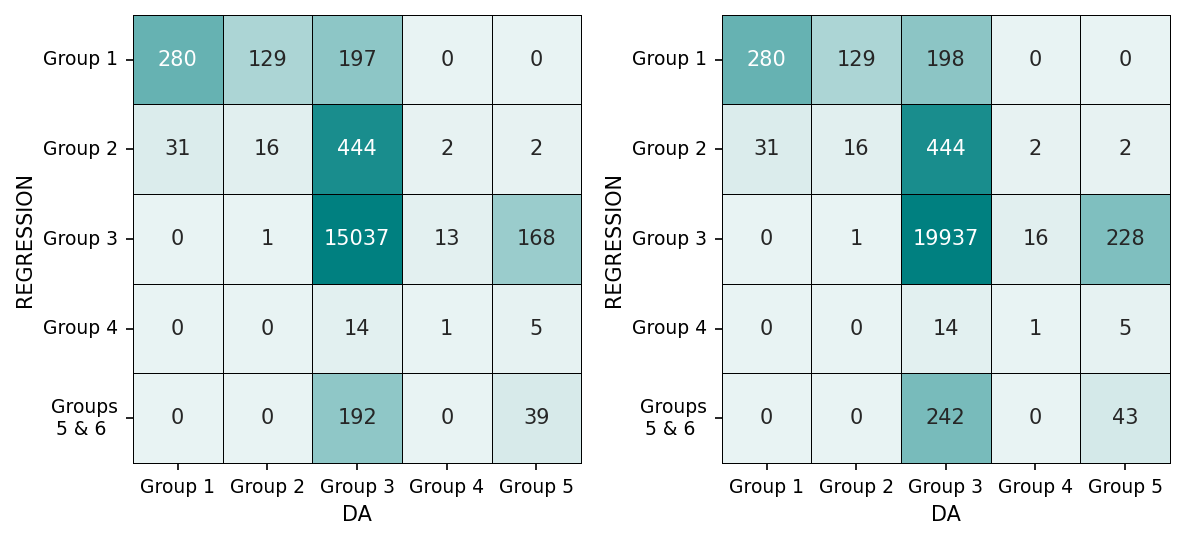

In [7]:
comparison_counts_noSilent = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO INITIAL CONFIDENCE GRADING', silent=False)
comparison_counts_Silent = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO INITIAL CONFIDENCE GRADING', silent=True)

plot_comparison_heatmap(comparison_counts_noSilent, comparison_counts_Silent, 500, saveName="../results/Figures/solo_regression_tier1_heatmap_initial_gradings.png")

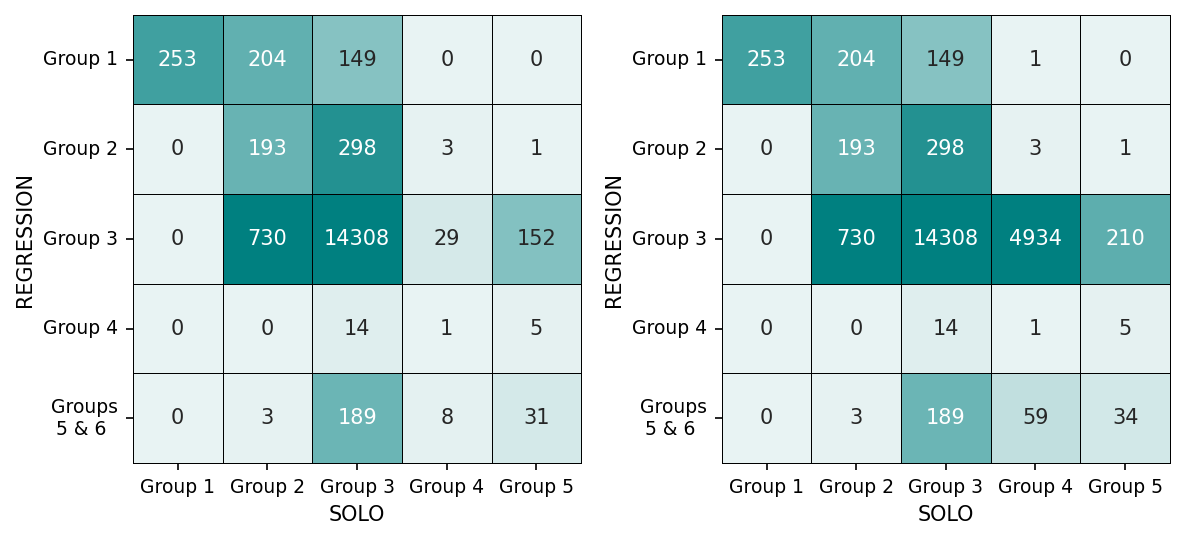

In [87]:
comparison_counts_noSilent = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=False)
comparison_counts_Silent = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

plot_comparison_heatmap(comparison_counts_noSilent, comparison_counts_Silent, 350, saveName="../results/Figures/solo_regression_tier1_heatmap.png")

In [96]:
# regression_drug_summary = pd.DataFrame(pd.concat([results_all_drugs, PTM_results]).groupby("Drug")['FINAL CONFIDENCE GRADING'].value_counts()).reset_index().rename(columns={"FINAL CONFIDENCE GRADING": "confidence"})

regression_drug_summary = pd.DataFrame(results_final.groupby("Drug")['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()).reset_index().rename(columns={"REGRESSION FINAL CONFIDENCE GRADING": "confidence"})

regression_drug_summary['confidence'] = regression_drug_summary['confidence'].replace('Assoc w R', 'Group 1').replace('Assoc w R - Interim', 'Group 2').replace('Assoc w S', 'Group 5').replace('Assoc w S - Interim', 'Group 4').replace('Neutral', 'Group 6')

regression_drug_summary = regression_drug_summary.pivot(index='confidence', columns='Drug', values='count').fillna(0).astype(int)
# solo_drug_summary = pd.DataFrame(results_all_drugs.groupby("Drug")['SOLO FINAL CONFIDENCE GRADING'].value_counts()).reset_index().rename(columns={"SOLO FINAL CONFIDENCE GRADING": "confidence"})

# drug_summary = pd.concat([regression_drug_summary, solo_drug_summary])
# regression_drug_summary = regression_drug_summary.loc[['1) Assoc w R', '2) Assoc w R - Interim', '6) Neutral', '4) Assoc w S - Interim', '5) Assoc w S']]
regression_drug_summary = regression_drug_summary.loc[['Group 1', 'Group 2', 'Group 6', 'Group 4', 'Group 5']]

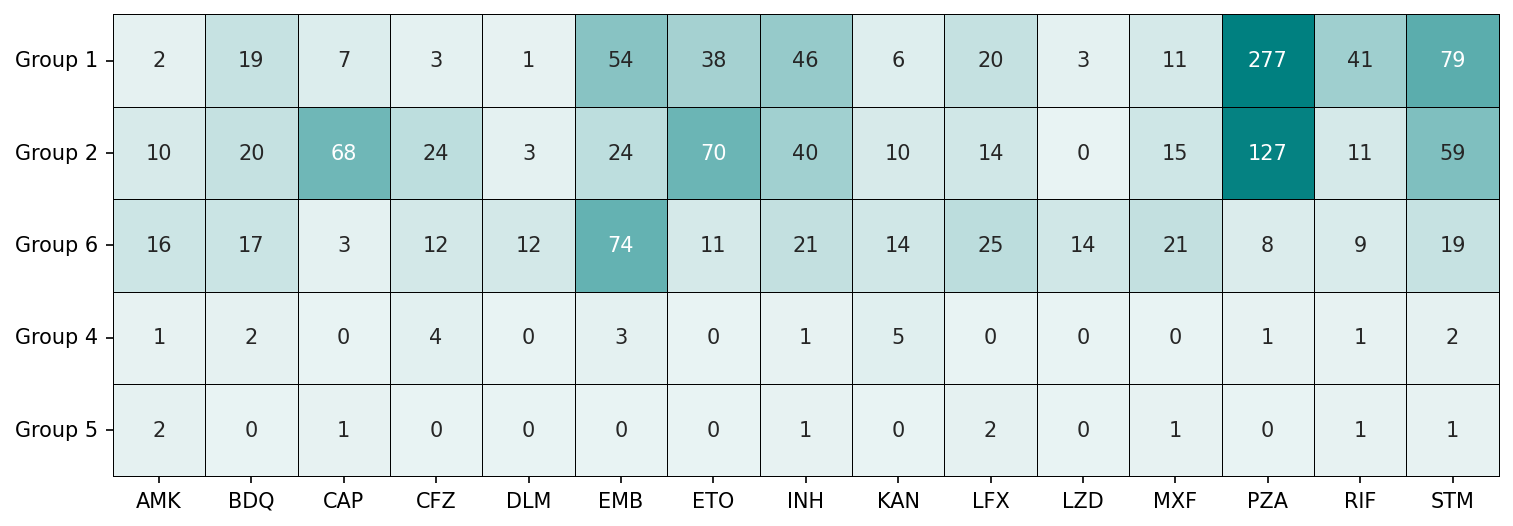

In [126]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.heatmap(regression_drug_summary, 
            fmt="g",
            cmap=sns.light_palette("teal", as_cmap=True),
            vmin=0,
            vmax=130,
            cbar=False,
            square=True,
            annot=True,
            annot_kws={"size": 10},
            linewidths=0.4, 
            linecolor='black',
            ax=ax,
            clip_on=False
           )

ax.set_xticks(ticks=ax.get_xticks(), labels=[drug_abbr_dict[drug] for drug in regression_drug_summary.columns], rotation=0)
ax.set_yticks(ticks=ax.get_yticks(), labels=ax.get_yticklabels(), rotation=0)

ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig("../results/Figures/summary_heatmap_by_drug.png", dpi=300, bbox_inches='tight')

# 0. Levofloxacin Lineage PC Investigation

## A. Plot coefficients with 5 PCs vs. 10/20/50/100
## B. Compare classifications -- make the 5 x 5 table like for comparing regression and SOLO

In [3]:
model_path = os.path.join(analysis_dir, "Levofloxacin", "BINARY", "tiers=1/phenos=WHO/dropAF_withSyn_unpooled")

# model_analysis_5PC = pd.read_csv(os.path.join(model_path, "model_analysis.csv"))
# model_analysis_100PC = pd.read_csv(os.path.join(model_path, "model_analysis_100PC.csv"))
# LRT_100PC = pd.read_csv(os.path.join(model_path, "LRT_results_100PC.csv"))
# LRT_100PC = add_pval_corrections(LRT_100PC.iloc[1:, ])

In [4]:
def combine_permutation_and_LRT(model_path, num_PCs):
    
    if num_PCs == 5:
        suffix = ""
    else:
        suffix = f"_{num_PCs}PC"
        
    model_analysis = pd.read_csv(os.path.join(model_path, f"model_analysis{suffix}.csv"))
    LRT_results = pd.read_csv(os.path.join(model_path, f"LRT_results{suffix}.csv"))
    
    if "mutation" not in LRT_results.columns:
        LRT_results.rename(columns={LRT_results.columns[0]: "mutation"}, inplace=True)
    
    LRT_results = add_pval_corrections(LRT_results.iloc[1:, ])
    
    return model_analysis.merge(LRT_results[["mutation", "BH_pval", "neutral_BH_pval"]].rename(columns={"BH_pval": "LRT_BH_pval"}), on="mutation")
#     final["PC"] = num_PCs
    
#     return final

In [5]:
def add_significance_category(df, tiers_lst, phenos_name, num_PCs):
    '''
    Add significance category annotations, in the form of integers. Add the ones with the fewest requirements first, and then progressively add
    '''
        
    if num_PCs != 5:
        col_name = f"regression_confidence_{num_PCs}PC"
    else:
        col_name = "regression_confidence"
    
    # lower significance threshold for tier 2 genes and if fit on ALL phenotypes
    if len(tiers_lst) == 2 or phenos_name == "ALL":
        thresh = 0.01
    else:
        thresh = 0.05
    
    # uncertain = significant coefficient, but it could be positive or negative
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] > 1), col_name] = "Possible Assoc w R"
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] < 1), col_name] = "Possible Assoc w S"
    
    # df.loc[(df[col_name] == "Possible Assoc w R") & 
    #        (df["LRT_BH_pval"] < thresh) & (df["PPV_LB"] >= 0.25), col_name] = "Assoc w R - rare"
    
    df.loc[(df[col_name] == "Possible Assoc w R") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["PPV_LB"] >= 0.25), col_name] = "Assoc w R - strict"
    
    # df.loc[(df[col_name] == "Possible Assoc w S") & 
    #        (df["LRT_BH_pval"] < thresh) & (df["NPV_LB"] >= 0.25), col_name] = "Assoc w S - rare"
    
    df.loc[(df[col_name] == "Possible Assoc w S") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["NPV_LB"] >= 0.25), col_name] = "Assoc w S - strict"

    # neutral mutations: not significant in regression AND significant in the neutral LRT test AND present at high enough frequency
    # should be in the lowest tail of the p-value.
    # so a mutation is significant in regression if p-value < 0.05, then a mutation is significant in the neutral test if p-value > 0.95
    # This means that more than 95% of permuted samples are NOT AS EXTREME as the test statistic, indicating the probably the test statistic is not significant
    df.loc[(df["BH_pval"] > (1-thresh)) & (df["neutral_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5), col_name] = "Neutral"
    
    # ALSO REPLACE THE UPPER OR LOWER BOUND OF THE ODDS RATIO WITH 1, DEPENDING ON THE DIRECTION
    df = df.reset_index(drop=True)

    df[col_name] = df[col_name].fillna("Uncertain")
    
    if num_PCs != 5:
        return df.rename(columns={"coef": f"coef_{num_PCs}PC"})
    else:
        return df

# 0. Look at Lineage Distribution for Individual Mutations

## what percentage of each lineage have this variant, independent of any phenotype. Ideally in the BDQ data binary dataset that was used to estimate its effect that we report in the slides



In [39]:
BDQ_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix.pkl"))
bdq_mic = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_mic.csv"))
bdq_phenos = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_binary.csv"))

In [55]:
var = "mmpL5_p.Thr794Ile"

# search_samples = set(BDQ_matrix.loc[BDQ_matrix[var]==1].index.values).intersection(bdq_mic.sample_id.values)
search_samples = BDQ_matrix.loc[BDQ_matrix[var]==1].index.values
print(len(search_samples))

final = pd.DataFrame(single_lineages.query("sample_id in @search_samples & ~Coll2014.str.contains(',')")["Lineage"].value_counts()).reset_index()
final = final.rename(columns={"index":"Lineage", "Lineage":f"{var}_Count"}).sort_values("Lineage")

1303


In [56]:
final

,Lineage,mmpL5_p.Thr794Ile_Count
2,1,109
0,2,875
1,3,307
3,BOV_AFRI,2


In [64]:
pd.DataFrame(single_lineages.merge(bdq_phenos.query("phenotypic_category=='WHO'"), on="sample_id")).Lineage.value_counts()

2           949
4           741
3           330
1           117
BOV_AFRI      2
Name: Lineage, dtype: int64

# 2. Lineage Counts per Drug Model

In [12]:
create_lineage_summary_df(single_lineages)

,Lineage,Count
0,1,4062
1,2,15829
2,3,5621
3,4,22730
4,Other,354


In [10]:
def compute_number_of_lineages_per_model(drugs_lst, lineages_df):
    
    lineage_summaries_by_drug = []
    
    for drug in drugs_lst:
        
        # fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
        fName = os.path.join(analysis_dir, drug, "phenos_binary.csv")

        if os.path.isfile(fName):
#             model_matrix = pd.read_pickle(fName)

#             samples = model_matrix.index.values
#             del model_matrix
            df_phenos = pd.read_csv(fName)
            samples = df_phenos["sample_id"].values
        
            single_drug_lineage_summary = create_lineage_summary_df(lineages_df.query("sample_id in @samples"), other_thresh=0.01)
            single_drug_lineage_summary["Drug"] = drug_abbr_dict[drug]

            lineage_summaries_by_drug.append(single_drug_lineage_summary)
        
    return pd.concat(lineage_summaries_by_drug, axis=0)

In [11]:
single_drug_lineage_summary = compute_number_of_lineages_per_model(os.listdir(analysis_dir), single_lineages)

In [17]:
single_drug_lineage_summary.pivot(index="Drug", columns="Lineage", values="Count")#.to_csv("ALL_isolates_by_lineage.csv")

Lineage,1,2,3,4,Other
Drug,,,,,
AMI,1286,9391,2216,11131,53
BDQ,833,5409,1376,6312,28
CAP,867,7177,1635,7104,25
CFZ,1097,5614,1964,5998,34
DLM,723,4335,1223,5350,29
EMB,3446,12867,4525,20791,321
ETH,1204,7812,1967,8694,47
INH,3669,14350,4985,21509,310
KAN,1334,9096,2275,10530,55


In [174]:
def compute_mean_resistance_by_primary_lineage(drug, lineages_df, resist_mean_thresh=0.1):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    
    # combine the lineages dataframe and the phenotypes dataframe for a single drug
    lineages_phenos_combined = lineages_df.merge(df_phenos, on="sample_id")
    # lineages_phenos_combined["L2"] = (lineages_phenos_combined["Lineage"] == "2").astype(int)

    R_summary = pd.DataFrame(lineages_phenos_combined.groupby("Lineage")["phenotype"].mean()).reset_index()

    # other_cols = L2_meanR_summary.query("phenotype < @resist_mean_thresh")["Lineage"].values
    # other_cols = ["BOV", "BOV_AFRI", "canetti"]
    
    # not enough data for L6 and L7. Don't show Bovis on here. L5 has a lot of 0 percent resistant, so doesn't appear a lot on the plot
    keep_cols = (np.arange(5) + 1).astype(str)
    R_summary = R_summary.query("Lineage in @keep_cols")

    R_summary = R_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    R_summary["Drug"] = drug_abbr_dict[drug]
    
    # this column is just to help sort the barplot, just aesthetics
    R_summary["max_R_single_drug"] = np.max(R_summary["phenotype"])
    return R_summary

In [175]:
R_by_lineage = []

for drug in np.sort(os.listdir(analysis_dir)):
    
    R_by_lineage.append(compute_mean_resistance_by_primary_lineage(drug, single_lineages))
    
R_by_lineage = pd.concat(R_by_lineage, axis=0)
assert R_by_lineage["phenotype"].min() <= 1
assert R_by_lineage["phenotype"].max() <= 1
# R_by_lineage = R_by_lineage.pivot(index="Drug", columns="Lineage", values="phenotype")

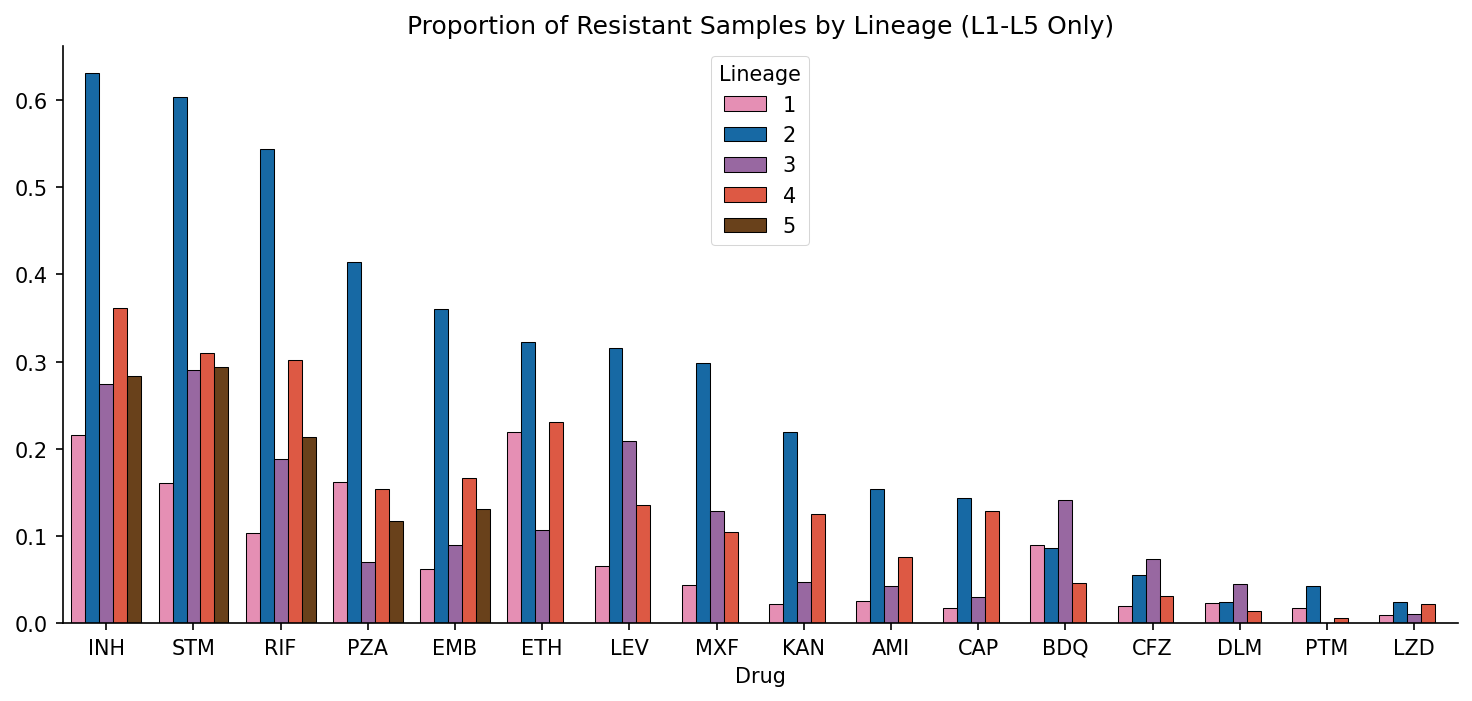

In [203]:
fig, ax = plt.subplots(figsize=(12, 5))

LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e"
                  }

sns.barplot(data=R_by_lineage.sort_values(["max_R_single_drug", "Lineage"], ascending=[False, True]),
            x="Drug",
            y="phenotype",
            hue="Lineage",
            edgecolor="black",
            palette=LinToColor_Dict,
            ax=ax
           )

plt.setp(ax.patches, linewidth=0.5)
plt.legend(title="Lineage", loc="upper center")
plt.ylabel("")
plt.title("Proportion of Resistant Samples by Lineage (L1-L5 Only)")
sns.despine()
plt.savefig("drug_resistance_by_lineage.png", dpi=300)

# 5. INH Compensatory and Neutral Controls

In [131]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]
print(len(np.unique(compens_lst)))

13


In [152]:
results_final.query("mutation in @compens_lst")[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'WHO_BH_LRT_pval', 'WHO_Present_R', 'WHO_Present_S', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'ALL_Present_R', 'ALL_Present_S', 'ALL_single_lineage', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'REGRESSION INITIAL CONFIDENCE GRADING', 'REGRESSION FINAL CONFIDENCE GRADING']].sort_values("ALL_Odds_Ratio", ascending=False)

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,WHO_BH_LRT_pval,WHO_Present_R,WHO_Present_S,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,ALL_Present_R,ALL_Present_S,ALL_single_lineage,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION INITIAL CONFIDENCE GRADING,REGRESSION FINAL CONFIDENCE GRADING
10380,Isoniazid,ahpC_c.-57C>T,1.164950,0.000000,0.000038,32.0,1.0,1.165688,0.000000,0.000013,46.0,2.0,NaN,3) Uncertain significance,3) Uncertain significance,Assoc w R,Assoc w R
10361,Isoniazid,ahpC_c.-48G>A,1.168466,0.000000,0.004848,113.0,7.0,1.161708,0.000000,0.000976,169.0,15.0,NaN,3) Uncertain significance,3) Uncertain significance,Assoc w R,Assoc w R
10366,Isoniazid,ahpC_c.-52C>T,1.138770,0.000000,0.000763,56.0,8.0,1.136834,0.000000,0.000334,96.0,10.0,NaN,3) Uncertain significance,3) Uncertain significance,Assoc w R,Assoc w R
10373,Isoniazid,ahpC_c.-54C>T,1.125298,0.000000,0.033517,25.0,2.0,1.133144,0.000000,0.001342,44.0,3.0,NaN,3) Uncertain significance,3) Uncertain significance,Assoc w R,Assoc w R
10393,Isoniazid,ahpC_c.-76T>A,1.138026,0.000000,0.000039,19.0,0.0,1.097204,0.000000,0.004384,26.0,1.0,3,3) Uncertain significance,3) Uncertain significance,Assoc w R,Assoc w R
10357,Isoniazid,ahpC_c.-47_-46insT,1.061279,0.000000,0.886362,34.0,0.0,1.083090,0.000000,0.552534,78.0,0.0,NaN,3) Uncertain significance,3) Uncertain significance,Uncertain,Uncertain
10389,Isoniazid,ahpC_c.-72C>T,1.045260,0.000000,0.586252,17.0,4.0,1.080957,0.000000,0.007806,37.0,4.0,NaN,3) Uncertain significance,3) Uncertain significance,Assoc w R,Assoc w R
10364,Isoniazid,ahpC_c.-52C>A,1.077763,0.000000,0.292193,32.0,2.0,1.073249,0.000000,0.530367,92.0,5.0,NaN,3) Uncertain significance,3) Uncertain significance,Uncertain,Uncertain
10363,Isoniazid,ahpC_c.-51G>A,1.059372,0.000000,0.886362,43.0,13.0,1.062916,0.000000,0.382876,67.0,14.0,NaN,3) Uncertain significance,3) Uncertain significance,Uncertain,Uncertain
10409,Isoniazid,ahpC_c.-81C>T,1.080169,0.000000,0.243420,43.0,7.0,1.042175,0.014000,1.000000,51.0,8.0,NaN,3) Uncertain significance,3) Uncertain significance,Uncertain,Uncertain


# 6. Direct Association-Based Prediction Comparison between SOLO and Regression

<ul>
    <li>SOLO vs. Regression-identified mutations</li>
    <li>Catalog method vs. Regression model</li>
    <li>+/- HETs</li>
</ul>


In [35]:
# def compute_ci_ztest(plot_df, metric, var1, var2, cat1, cat2):

#     if metric != 'F1':
#         cat1_numerator = plot_df.loc[cat1, var1]
#         cat1_denominator = plot_df.loc[cat1, var1] + plot_df.loc[cat1, var2]
    
#         cat2_numerator = plot_df.loc[cat2, var1]
#         cat2_denominator = plot_df.loc[cat2, var1] + plot_df.loc[cat2, var2]
#     else:
#         cat1_numerator = 2 * plot_df.loc[cat1, 'TP']
#         cat1_denominator = 2 * plot_df.loc[cat1, 'TP'] + plot_df.loc[cat1, 'FP'] + plot_df.loc[cat1, 'FN']

#         cat2_numerator = 2 * plot_df.loc[cat1, 'TP']
#         cat2_denominator = 2 * plot_df.loc[cat1, 'TP'] + plot_df.loc[cat1, 'FP'] + plot_df.loc[cat1, 'FN']

#     twoSided_pval = statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
#                                                                    [cat1_denominator, cat2_denominator]
#                                                                   , alternative='two-sided')[1]

#     if twoSided_pval < 0.05:
#         return twoSided_pval
        
#         # greater_pval = statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
#         #                                                          [cat1_denominator, cat2_denominator]
#         #                                                           , alternative='larger')[1]
#         # if greater_pval < 0.05:
#         #     return greater_pval
#         # else:
#         #     # return less than p-value
#         #     return statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
#         #                                                      [cat1_denominator, cat2_denominator]
#         #                                                       , alternative='smaller')[1]
#     else:
#         # not significant
#         return None

In [8]:
def single_metric_solo_regression_comparison(drugs_lst, metric="Sens", saveName=None):

    fig, axs = plt.subplots(3, 5, figsize=(11, 11), sharex=True, sharey=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=0.05)

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":
            # stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0]).reset_index()
            # stats['Drug'] = drug
            # stats['Model'] = 'Regression Initial'
            
            stats_solo_initial = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_SOLO_initial_withLoF.csv"))
            stats_solo_initial['Drug'] = drug
            stats_solo_initial['Model'] = 'DA'
            
            stats_solo_final = solo_binary_stats.query("Drug==@drug").reset_index()
            stats_solo_final['Model'] = 'SOLO'
            
            # stats_solo_final = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_SOLO_final.csv"), index_col=[0]).reset_index()
            # stats_solo_final['Drug'] = drug
            # stats_solo_final['Model'] = 'SOLO'

            stats_regression = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_withLoF.csv"))
            stats_regression['Drug'] = drug
            
            # plot_df.append(stats)
            plot_df.append(stats_solo_initial)
            plot_df.append(stats_solo_final)
            plot_df.append(stats_regression)

    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')
    
    # Categories and metric names
    # categories = ['SOLO Initial', 'SOLO Final', 'Regression Initial', 'Regression Final']
    categories = ['DA', 'SOLO', 'Regression']

    # SOLO green, Regression orange
    colors = {'DA': sns.color_palette("Set3").as_hex()[0],#sns.color_palette("Set2")[0], 
              'Regression': sns.color_palette("Set3").as_hex()[5], #sns.color_palette("Set2")[1], 
              'SOLO': sns.color_palette("Set3").as_hex()[2], #sns.color_palette("Set2")[2]
             }
    
    # colors = dict(zip(categories, np.concatenate([sns.color_palette("Paired")[:2], sns.color_palette("Paired")[6:8]])))
    
    # Bar width and positions
    bar_width = 0.05
    # bar_positions = np.arange(len(categories))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):

        single_drug_plot_df = plot_df.query("Drug==@drug")
        del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric

        var1, var2 = metrics_components_dict[metric]
        # metric_pval = compute_ci_ztest(single_drug_plot_df, metric, var1, var2, single_drug_plot_df.index.values[0], single_drug_plot_df.index.values[1])
        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = single_drug_plot_df.loc[category][metric] * 100
            lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
            upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')#, alpha=0.75)
            ax.bar_label(patch, label_type='center', fmt='%.1f')
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
        
        ax.set_title(drug, fontsize=10)
        
        # remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Show the plot
    # plt.legend(bbox_to_anchor=(0.08, -0.17), loc="lower right", ncol=len(categories))
    plt.legend(bbox_to_anchor=(-0.55, -0.17), loc="lower right", ncol=len(categories))
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches="tight")

    return plot_df

In [32]:
binary_metrics_df.query("Drug=='Linezolid'")

,Sens,Sens_lb,Sens_ub,Spec,Spec_lb,Spec_ub,F1,F1_lb,F1_ub,PPV,...,NPV_lb,NPV_ub,PropR,PropR_lb,PropR_ub,TP,TN,FP,FN,Drug
Model,,,,,,,,,,,,,,,,,,,,,
DA,0.318182,0.271244,0.368026,0.998186,0.997439,0.998759,0.453333,0.410165,0.497030,0.788079,...,0.983872,0.987410,0.020766,0.018734,0.022956,119,17604,32,255,Linezolid
SOLO,0.340000,0.292000,0.390000,0.998000,0.997000,0.999000,0.473881,0.430922,0.517129,0.784000,...,0.984000,0.988000,0.021000,0.019000,0.023000,127,17601,35,247,Linezolid
Regression,0.328877,0.281447,0.379042,0.998072,0.997307,0.998665,0.463277,0.420229,0.506735,0.783439,...,0.984104,0.987616,0.020766,0.018734,0.022956,123,17602,34,251,Linezolid


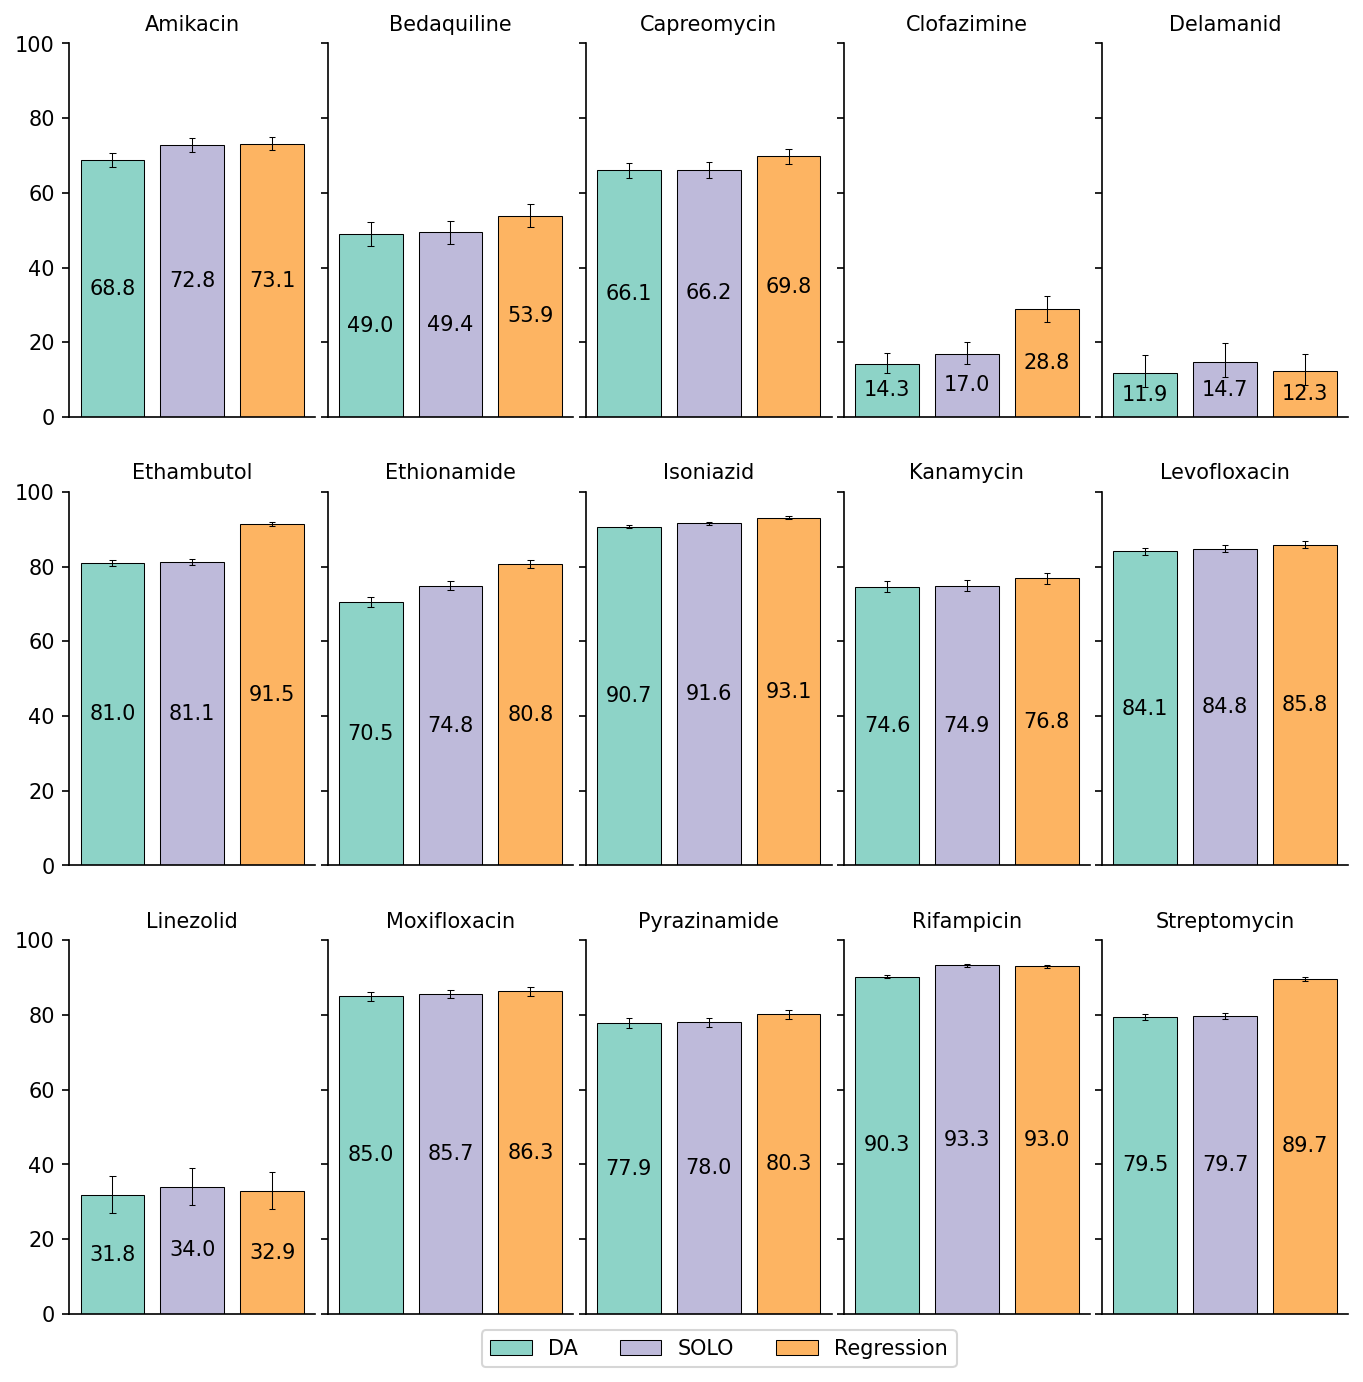

In [9]:
binary_metrics_df = single_metric_solo_regression_comparison(drugs_lst, metric="Sens", saveName="../results/Figures/solo_regression_sensitivity_withLoF.png")

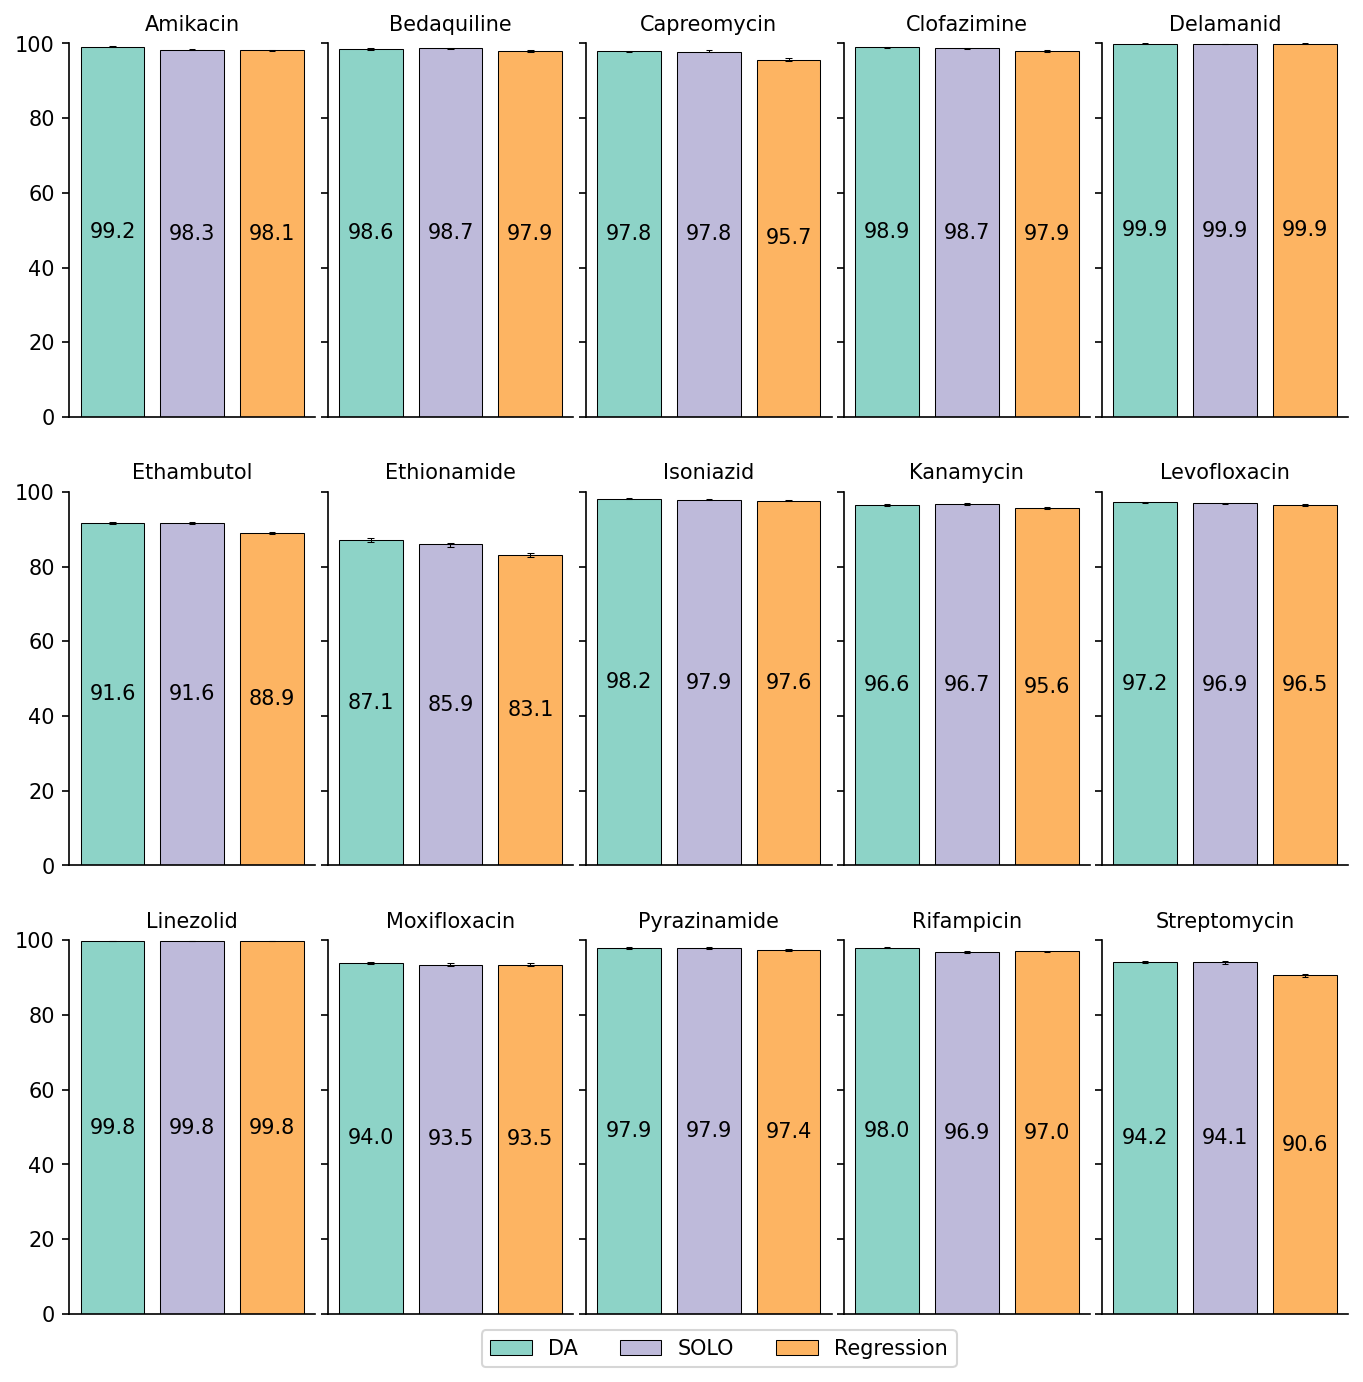

In [10]:
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Spec", saveName="../results/Figures/solo_regression_specificity_withLoF.png")

In [12]:
binary_metrics_df.loc['DA']['F1'].mean(), binary_metrics_df.loc['SOLO']['F1'].mean(), binary_metrics_df.loc['Regression']['F1'].mean()

(0.6918524959127681, 0.6994689238258516, 0.7051954188797782)

In [320]:
# 3xclude LoF variants, but not for SOLO FINAL
R_assoc_counts = pd.DataFrame(results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("~mutation.str.contains('LoF')").Drug.value_counts()).rename(columns={'count': 'Regression'}).merge(pd.DataFrame(who_variants.loc[(~pd.isnull(who_variants['INITIAL CONFIDENCE GRADING'])) & (who_variants['INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))].query("~variant.str.contains('LoF')").drug.value_counts()).rename(columns={'count': 'SOLO Initial'}).merge(pd.DataFrame(who_variants.loc[who_variants['FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].drug.value_counts()).rename(columns={'count': 'SOLO Final'}), left_index=True, right_index=True), left_index=True, right_index=True)

R_assoc_counts = R_assoc_counts.sort_index()

In [356]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("~mutation.str.contains('LoF') & Drug == 'Linezolid'")

,Drug,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,...,ALL_Spec_UB,Initial confidence grading ALL dataset,UNPOOLED CONFIDENCE GRADING,Reason,POOLED CONFIDENCE GRADING,ALL_single_lineage,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION INITIAL CONFIDENCE GRADING,REGRESSION FINAL CONFIDENCE GRADING
14980,Linezolid,rplC_p.Cys154Arg,missense_variant,2.233070,0.0,0.0,1.0,1.0,0.000000e+00,1.0,...,0.999174,Assoc w R,Assoc w R,WHO ALL Same Grading,Assoc w R,NaN,1) Assoc w R,1) Assoc w R,Assoc w R,Assoc w R
15312,Linezolid,rrl_n.2270G>T,non_coding_transcript_exon_variant,1.297064,0.0,0.0,1.0,1.0,2.806320e-34,1.0,...,0.999931,Assoc w R,Assoc w R,WHO ALL Same Grading,Assoc w R,NaN,3) Uncertain significance,2) Assoc w R - Interim,Assoc w R,Assoc w R
15470,Linezolid,rrl_n.2814G>T,non_coding_transcript_exon_variant,1.303863,0.0,0.0,1.0,1.0,1.423537e-79,1.0,...,0.999931,Assoc w R,Assoc w R,WHO ALL Same Grading,Assoc w R,NaN,1) Assoc w R,2) Assoc w R - Interim,Assoc w R,Assoc w R


In [358]:
who_variants.loc[(~pd.isnull(who_variants['INITIAL CONFIDENCE GRADING'])) & (who_variants['INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))].query("~variant.str.contains('LoF') & drug == 'Linezolid'")

,drug,gene,variant,tier,effect,genomic position,algorithm_pass,Present_SOLO_SR,Present_SOLO_R,Present_SOLO_S,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
14980,Linezolid,rplC,rplC_p.Cys154Arg,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",1.0,79.0,64.0,15.0,...,NaN,1) Assoc w R,NaN,No change,NaN,NaN,yes,NaN,NaN,1
15470,Linezolid,rrl,rrl_n.2814G>T,1,non_coding_transcript_exon_variant,1476471,1.0,9.0,7.0,2.0,...,Evidence from ALL dataset only,2) Assoc w R - Interim,NaN,UP from Uncertain to AwRI,NaN,NaN,yes,ALL only,NaN,4


In [321]:
R_assoc_counts

,Regression,SOLO Initial,SOLO Final
Amikacin,12,2,4
Bedaquiline,37,23,88
Capreomycin,74,7,70
Clofazimine,26,2,59
Delamanid,3,1,30
Ethambutol,78,13,13
Ethionamide,106,23,287
Isoniazid,85,8,143
Kanamycin,16,7,8
Levofloxacin,34,14,18


In [322]:
R_assoc_counts.sum(axis=0)

Regression      1091
SOLO Initial     448
SOLO Final      1383
dtype: int64

In [13]:
diff_df_SOLO_initial = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_SOLO_initial.index.values:
    for metric in diff_df_SOLO_initial.columns:
        diff_df_SOLO_initial.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["DA", metric]

diff_df_SOLO_initial['combined_diff'] = (np.abs(diff_df_SOLO_initial['Sens']) + np.abs(diff_df_SOLO_initial['Spec'])) / 2

In [340]:
diff_df_SOLO_final = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_SOLO_final.index.values:
    for metric in diff_df_SOLO_final.columns:
        diff_df_SOLO_final.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["SOLO", metric]

In [341]:
len(diff_df_SOLO_final.query("Sens > 0")), len(diff_df_SOLO_final.query("Sens == 0")), len(diff_df_SOLO_final.query("Sens < 0"))

(11, 0, 4)

In [342]:
len(diff_df_SOLO_final.query("Spec > 0")), len(diff_df_SOLO_final.query("Spec == 0")), len(diff_df_SOLO_final.query("Spec < 0"))

(3, 0, 12)

In [14]:
len(diff_df_SOLO_initial.query("Sens > 0")), len(diff_df_SOLO_initial.query("Sens == 0")), len(diff_df_SOLO_initial.query("Sens < 0"))

(15, 0, 0)

In [20]:
diff_df_SOLO_initial.Sens.min()*100, diff_df_SOLO_initial.Sens.max()*100

(0.3968253968253996, 14.47562776957164)

In [21]:
diff_df_SOLO_initial.Spec.min()*100, np.sort(diff_df_SOLO_initial.Spec)[-2]*100

(-3.9885313794202015, -0.011340440009088848)

In [23]:
diff_df_SOLO_initial.Sens.mean()*100, diff_df_SOLO_initial.Spec.mean()*100

(4.845444676313416, -1.2875657726653216)

In [15]:
len(diff_df_SOLO_initial.query("Spec > 0")), len(diff_df_SOLO_initial.query("Spec == 0")), len(diff_df_SOLO_initial.query("Spec < 0"))

(0, 1, 14)

In [16]:
diff_df_SOLO_initial.query("Spec == 0")

,Sens,Spec,PPV,NPV,F1,combined_diff
Delamanid,0.003968,0.0,0.004979,0.000083,0.006181,0.001984


In [338]:
diff_df_SOLO_initial.Sens.mean()*100, diff_df_SOLO_initial.Spec.mean()*100

(6.3387734322216085, -1.533588690984785)

In [362]:
binary_metrics_df.loc[['DA', 'Regression']].query("Drug=='Linezolid'")[['Sens', 'Sens_lb']]

,Sens,Sens_lb,Sens_ub,Spec,Spec_lb,Spec_ub,F1,F1_lb,F1_ub,PPV,...,NPV_lb,NPV_ub,PropR,PropR_lb,PropR_ub,TP,TN,FP,FN,Drug
Model,,,,,,,,,,,,,,,,,,,,,
DA,0.318182,0.271244,0.368026,0.998186,0.997439,0.998759,0.453333,0.410165,0.497030,0.788079,...,0.983872,0.987410,0.020766,0.018734,0.022956,119,17604,32,255,Linezolid
Regression,0.328877,0.281447,0.379042,0.998072,0.997307,0.998665,0.463277,0.420229,0.506735,0.783439,...,0.984104,0.987616,0.020766,0.018734,0.022956,123,17602,34,251,Linezolid


In [29]:
diff_df_SOLO_initial.sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1,combined_diff
Clofazimine,0.144756,-0.00984,0.01159,0.006145,0.125487,0.077298
Ethambutol,0.104446,-0.026766,-0.032454,0.027254,0.022449,0.065606
Ethionamide,0.102271,-0.039885,-0.031269,0.029747,0.023765,0.071078
Streptomycin,0.102113,-0.035986,-0.037315,0.055916,0.035325,0.06905
Bedaquiline,0.04918,-0.006948,-0.063328,0.003415,0.009959,0.028064
Amikacin,0.043952,-0.010571,-0.089893,0.00433,-0.010667,0.027261
Capreomycin,0.037772,-0.02166,-0.1209,0.003831,-0.034891,0.029716
Rifampicin,0.027223,-0.009783,-0.016397,0.013487,0.006264,0.018503
Isoniazid,0.024008,-0.005765,-0.00709,0.016073,0.009319,0.014887
Pyrazinamide,0.023922,-0.005033,-0.01675,0.005503,0.006175,0.014478


In [30]:
diff_df_SOLO_initial.sort_values("Spec", ascending=True)

,Sens,Spec,PPV,NPV,F1,combined_diff
Ethionamide,0.102271,-0.039885,-0.031269,0.029747,0.023765,0.071078
Streptomycin,0.102113,-0.035986,-0.037315,0.055916,0.035325,0.06905
Ethambutol,0.104446,-0.026766,-0.032454,0.027254,0.022449,0.065606
Capreomycin,0.037772,-0.02166,-0.1209,0.003831,-0.034891,0.029716
Amikacin,0.043952,-0.010571,-0.089893,0.00433,-0.010667,0.027261
Clofazimine,0.144756,-0.00984,0.01159,0.006145,0.125487,0.077298
Rifampicin,0.027223,-0.009783,-0.016397,0.013487,0.006264,0.018503
Kanamycin,0.021575,-0.00947,-0.038355,0.003117,-0.007959,0.015522
Bedaquiline,0.04918,-0.006948,-0.063328,0.003415,0.009959,0.028064
Levofloxacin,0.017535,-0.006727,-0.020421,0.004244,-0.00079,0.012131


In [353]:
diff_df_SOLO_initial.loc[diff_df_SOLO_initial['Spec'] < -0.01].sort_values("Spec", ascending=True)

,Sens,Spec,PPV,NPV,F1,combined_diff
Ethionamide,0.175539,-0.062249,-0.064097,0.045668,0.055195,0.118894
Streptomycin,0.123439,-0.045189,-0.053028,0.064393,0.04296,0.084314
Ethambutol,0.104446,-0.026766,-0.032454,0.027254,0.022449,0.065606
Capreomycin,0.064407,-0.022107,-0.121346,0.00704,-0.017238,0.043257
Clofazimine,0.20384,-0.014339,-0.068221,0.008497,0.226037,0.10909
Amikacin,0.043952,-0.010571,-0.089893,0.00433,-0.010667,0.027261


In [28]:
# regression higher, regression lower. Delamanid is the same because the same mutations were graded by both methods
len(diff_df.query("Spec > 0")), len(diff_df.query("Spec == 0")), len(diff_df.query("Spec < 0"))

(0, 1, 14)

In [38]:
# regression higher, regression lower. Delamanid is the same because the same mutations were graded by both methods
len(diff_df_SOLO_final.query("Sens > 0")), len(diff_df_SOLO_final.query("Sens == 0")), len(diff_df_SOLO_final.query("Sens < 0"))

(12, 0, 3)

In [39]:
# regression higher, regression lower. Delamanid is the same because the same mutations were graded by both methods
len(diff_df_SOLO_final.query("Spec > 0")), len(diff_df_SOLO_final.query("Spec == 0")), len(diff_df_SOLO_final.query("Spec < 0"))

(3, 0, 12)

In [31]:
# regression sensitivity greater than SOLO and regression specificity less than SOLO
print(diff_df.query("Sens > 0 & Spec < 0").sort_values("Sens", ascending=False).shape)
diff_df.query("Sens > 0 & Spec < 0").sort_values("Sens", ascending=False)

(14, 5)


,Sens,Spec,PPV,NPV,F1
Clofazimine,0.144756,-0.00984,0.01159,0.006145,0.125487
Ethambutol,0.104446,-0.026766,-0.032454,0.027254,0.022449
Ethionamide,0.102271,-0.039885,-0.031269,0.029747,0.023765
Streptomycin,0.102113,-0.035986,-0.037315,0.055916,0.035325
Bedaquiline,0.04918,-0.006948,-0.063328,0.003415,0.009959
Amikacin,0.043952,-0.010571,-0.089893,0.00433,-0.010667
Capreomycin,0.037772,-0.02166,-0.1209,0.003831,-0.034891
Rifampicin,0.027223,-0.009783,-0.016397,0.013487,0.006264
Isoniazid,0.024008,-0.005765,-0.00709,0.016073,0.009319
Pyrazinamide,0.023922,-0.005033,-0.01675,0.005503,0.006175


In [35]:
# regression sensitivity less than SOLO and regression specificity greater than SOLO
diff_df.query("Sens < 0").sort_values("Sens")

,Sens,Spec,PPV,NPV,F1
Amikacin,-0.039694,0.008453,0.071842,-0.003884,0.005045
Linezolid,-0.011123,0.000072,-0.000561,-0.000059,-0.010604
Delamanid,-0.008111,0.000394,0.108333,-0.000451,-0.006129
Bedaquiline,-0.007983,0.001472,0.017466,-0.00054,-0.000297
Rifampicin,-0.001501,-0.000585,-0.00045,-0.000199,-0.001088


# Amikacin simulation: Add 2 additional mutations identified by grading rules

In [3]:
AMI_results = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Amikacin/BINARY/tiers=1/phenos=ALL/model_stats_AF75.csv")
AMI_results_simulated = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Amikacin/BINARY/tiers=1/phenos=ALL/model_stats_AF75_5Muts.csv")

In [4]:
AMI_results

,Model,Sens,Sens_lb,Sens_ub,Spec,Spec_lb,Spec_ub,F1,F1_lb,F1_ub,...,Accuracy,Accuracy_lb,Accuracy_ub,BalancedAcc,BalancedAcc_lb,BalancedAcc_ub,TP,TN,FP,FN
0,Catalog,0.688306,0.669661,0.706506,0.991453,0.990154,0.992621,0.779986,0.767415,0.792183,...,0.961028,0.95854,0.963407,0.83988,0.839811,0.839948,1707,22040,190,773


In [5]:
AMI_results_simulated

,Model,Sens,Sens_lb,Sens_ub,Spec,Spec_lb,Spec_ub,F1,F1_lb,F1_ub,...,Accuracy,Accuracy_lb,Accuracy_ub,BalancedAcc,BalancedAcc_lb,BalancedAcc_ub,TP,TN,FP,FN
0,Catalog,0.728226,0.710253,0.745659,0.981107,0.97923,0.982856,0.767531,0.755192,0.779537,...,0.955726,0.953087,0.958258,0.854666,0.8546,0.854732,1806,21810,420,674


In [11]:
solo_binary_stats.query("Drug=='Amikacin'")

,Drug,Sens,Spec,PPV,NPV,F1,PropR,Sens_lb,Sens_ub,Spec_lb,...,NPV_lb,NPV_ub,F1_lb,F1_ub,PropR_lb,PropR_ub,TP,TN,FP,FN
Model,,,,,,,,,,,,,,,,,,,,,
SOLO,Amikacin,0.728,0.983,0.828,0.97,0.774941,0.1,0.71,0.746,0.981,...,0.968,0.972,0.762674,0.786862,0.097,0.104,1806,21855,375,674


In [9]:
AMI_results_simulated['Spec'].values[0] - AMI_results['Spec'].values[0]

-0.010346378767431608

In [365]:
pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0])

,Sens,Sens_lb,Sens_ub,Spec,Spec_lb,Spec_ub,F1,F1_lb,F1_ub,PPV,...,Accuracy,Accuracy_lb,Accuracy_ub,BalancedAcc,BalancedAcc_lb,BalancedAcc_ub,TP,TN,FP,FN
Model,,,,,,,,,,,,,,,,,,,,,
Regression,0.929897,0.925939,0.933706,0.970132,0.968172,0.972003,0.937123,0.934469,0.9397,0.944461,...,0.955919,0.954039,0.957743,0.950015,0.950001,0.950028,15679,29947,922,1182


In [401]:
for drug in drugs_lst:

    if drug != 'Pretomanid':
        fName = os.path.join(analysis_dir, drug, "BINARY/tiers=1/phenos=ALL/model_stats_AF25_SOLO_final.csv")
        df = pd.read_csv(fName)
        df['Model'] = 'SOLO Final'
        df.to_csv(fName, index=False)

In [402]:
pd.read_csv(fName)

,Model,Sens,Sens_lb,Sens_ub,Spec,Spec_lb,Spec_ub,F1,F1_lb,F1_ub,...,Accuracy,Accuracy_lb,Accuracy_ub,BalancedAcc,BalancedAcc_lb,BalancedAcc_ub,TP,TN,FP,FN
0,SOLO Final,0.943776,0.940192,0.947205,0.968253,0.966236,0.970181,0.942881,0.940352,0.945333,...,0.959606,0.957801,0.961355,0.956014,0.956002,0.956027,15913,29889,980,948


In [14]:
# _ = single_metric_solo_regression_comparison(drugs_lst, metric="PPV", saveName="../results/SOLO_Regression_Comparison/PPV.png")

In [102]:
# _ = single_metric_solo_regression_comparison(drugs_lst, metric="NPV", saveName="../results/SOLO_Regression_Comparison/NPV.png")

In [47]:
def single_metric_HET_comparison(drugs_lst, metric="Sens", solo=False, plot=True, title=None, saveName=None):

    if solo:
        suffix = "_SOLO_initial"
        model_name = "SOLO Initial"
    else:
        suffix = ""
        model_name = "Regression"

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":
            stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75{suffix}_withLoF.csv"))
            stats_het = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF25{suffix}_withLoF.csv"))

            stats['Model'] = ['AF = 75%']
            stats['Drug'] = drug
            
            stats_het['Model'] = ['AF = 25%']
            stats_het['Drug'] = drug

            plot_df.append(stats)
            plot_df.append(stats_het)
        
    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')

    if plot:

        fig, axs = plt.subplots(3, 5, figsize=(8, 11), sharex=True, sharey=True)
        axs = axs.flatten()
        plt.subplots_adjust(wspace=0.05)
        
        # Categories and metric names
        categories = plot_df.index.unique()
    
        # keep orange color (index 1) for regression, then select the next color for +HETs
        colors = {'AF = 75%': sns.color_palette("Set3").as_hex()[5], 'AF = 25%': sns.color_palette("Set3").as_hex()[4]}
        
        # Bar width and positions
        bar_width = 0.05
        # bar_positions = np.arange(len(categories))
        
        errwidth = 0.04
        errlinewidth = 0.5
        
        for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):
    
            single_drug_plot_df = plot_df.query("Drug==@drug")
            del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric
    
            var1, var2 = metrics_components_dict[metric]        
            ax = axs[i]
            
            # Plot bars for each category
            for j, category in enumerate(categories):
        
                test = single_drug_plot_df.loc[category][metric] * 100
                lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
                upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
                
                # Plot the test value as a bar
                patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')
                ax.bar_label(patch, label_type='center', fmt='%.1f')
                
                # Plot the confidence interval as a vertical line
                ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
        
                # plot horizontal lines to make the error bars look nicer
                ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
                ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
    
            ax.set_title(drug, fontsize=10)
            
            # remove x-axis ticks and labels
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        # Show the plot
        plt.legend(bbox_to_anchor=(-0.5, -0.17), loc="lower right", ncol=len(categories))
        sns.despine()
        plt.tight_layout()
        plt.ylim(0, 100)
    
        if title is not None:
            plt.suptitle(title)
        
        sns.despine()
    
        if saveName is None:
            plt.show()
        else:
            plt.savefig(saveName, dpi=300, bbox_inches="tight")

    return plot_df

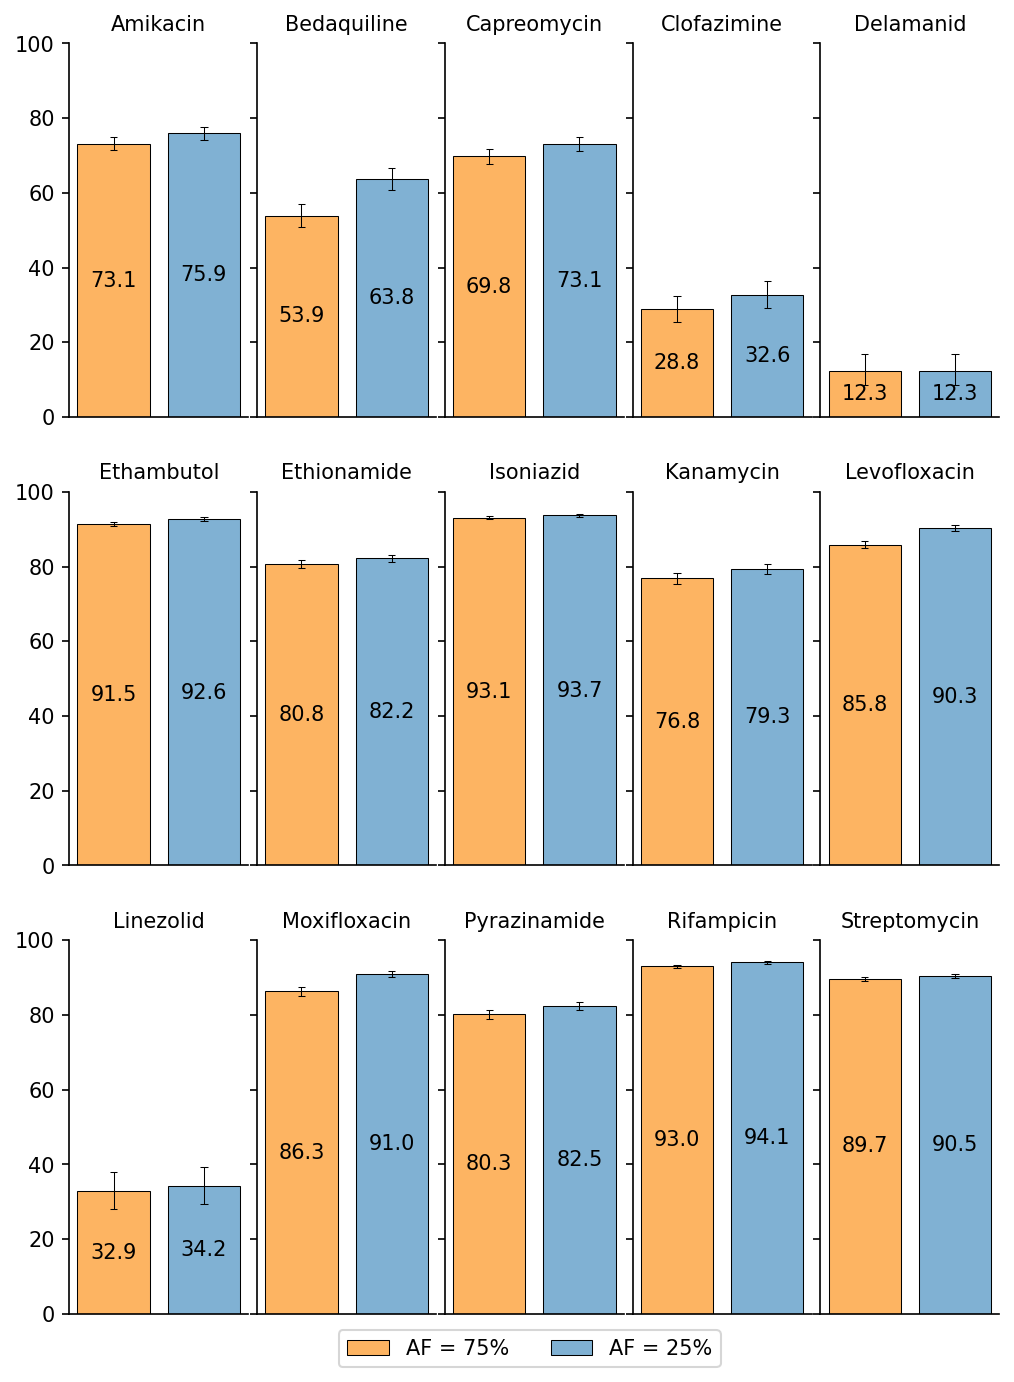

In [26]:
HET_results = single_metric_HET_comparison(drugs_lst, metric="Sens", saveName="../results/Figures/regression_HETs_sensitivity_withLoF.png")

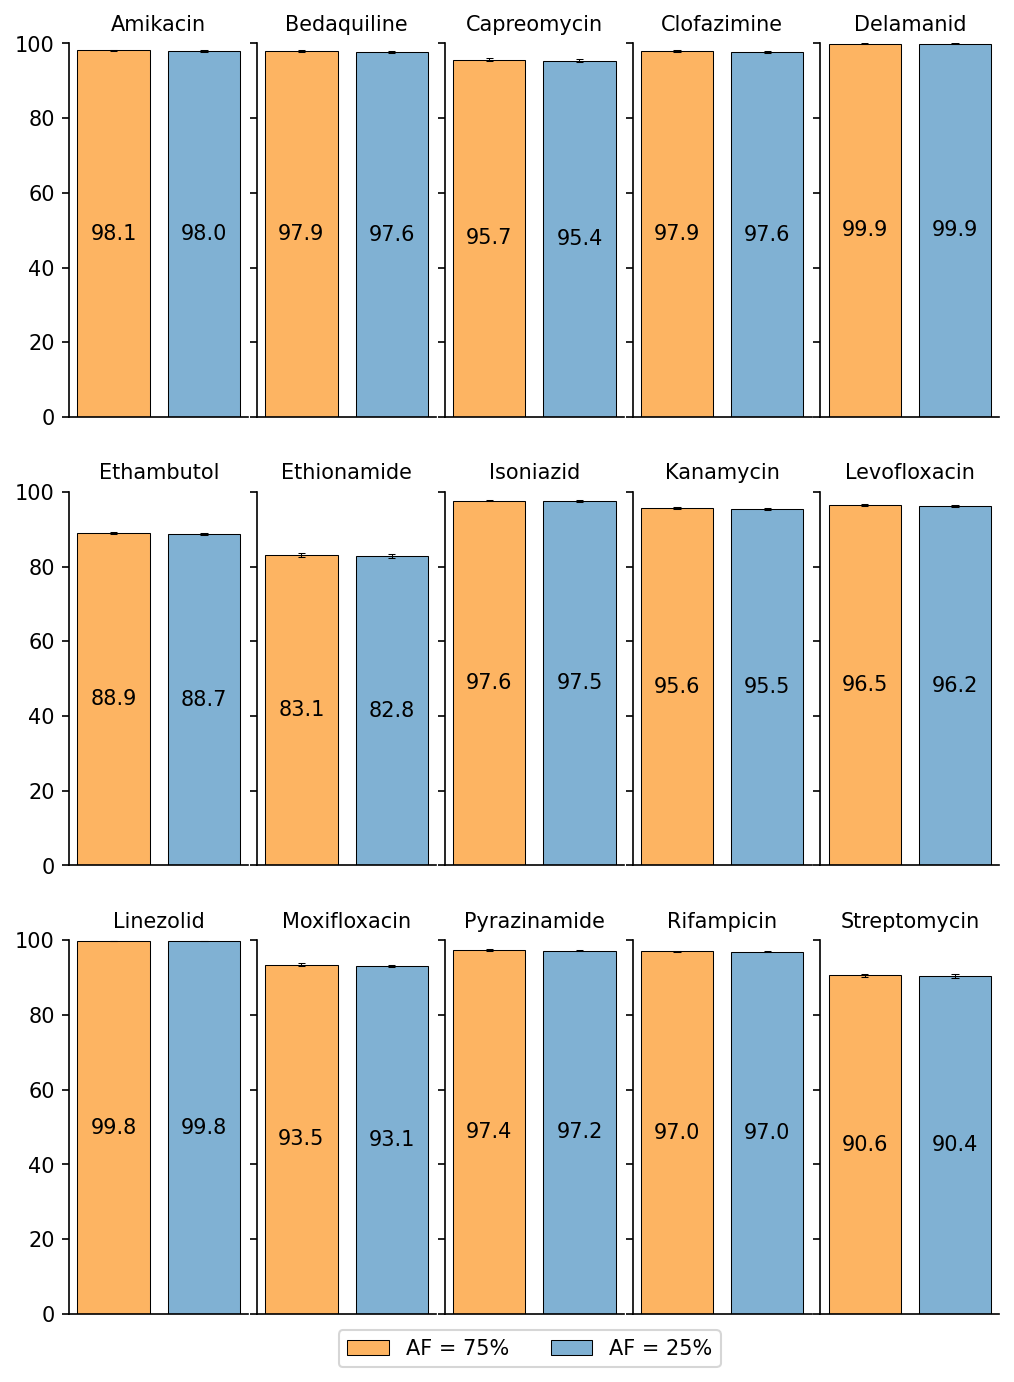

In [27]:
_ = single_metric_HET_comparison(drugs_lst, metric="Spec", saveName="../results/Figures/regression_HETs_specificity_withLoF.png")

In [48]:
HET_results_SOLO_initial = single_metric_HET_comparison(drugs_lst, metric="Sens", plot=False, solo=True)

In [33]:
diff_df_HET = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_HET.index.values:

    for metric in diff_df_HET.columns:
        diff_df_HET.loc[drug, metric] = HET_results.query("Drug==@drug").loc["AF = 25%", metric] - HET_results.query("Drug==@drug").loc["AF = 75%", metric]

In [42]:
HET_results.query("Drug=='Capreomycin'")

,Sens,Sens_lb,Sens_ub,Spec,Spec_lb,Spec_ub,F1,F1_lb,F1_ub,PPV,...,Accuracy_lb,Accuracy_ub,BalancedAcc,BalancedAcc_lb,BalancedAcc_ub,TP,TN,FP,FN,Drug
Model,,,,,,,,,,,,,,,,,,,,,
AF = 75%,0.698305,0.677995,0.718051,0.956744,0.953439,0.959878,0.689293,0.675022,0.703299,0.680510,...,0.922682,0.930418,0.827525,0.827432,0.827617,1442,14974,677,623,Capreomycin
AF = 25%,0.730751,0.711058,0.749786,0.953933,0.950531,0.957164,0.702678,0.688757,0.716322,0.676682,...,0.924011,0.931684,0.842342,0.842253,0.842430,1509,14930,721,556,Capreomycin


In [36]:
diff_df_HET.sort_values('Sens', ascending=False)

,Sens,Spec,PPV,NPV,F1
Bedaquiline,0.099325,-0.002519,0.01241,0.007454,0.062131
Moxifloxacin,0.04665,-0.003679,-0.000456,0.010105,0.019051
Levofloxacin,0.044603,-0.002673,-0.002626,0.011641,0.020647
Clofazimine,0.038405,-0.003022,-0.002822,0.001651,0.023421
Capreomycin,0.032446,-0.002811,-0.003828,0.00404,0.013385
Amikacin,0.027419,-0.001305,-0.004583,0.00291,0.012753
Kanamycin,0.024657,-0.001475,-0.000303,0.004004,0.011671
Pyrazinamide,0.022343,-0.001303,-0.002079,0.005401,0.011217
Ethionamide,0.013929,-0.003568,-0.000907,0.004578,0.004563
Linezolid,0.013369,-0.000397,-0.026043,0.000271,0.008178


In [49]:
diff_df_HET_SOLO_initial = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_HET_SOLO_initial.index.values:

    for metric in diff_df_HET.columns:
        diff_df_HET_SOLO_initial.loc[drug, metric] = HET_results_SOLO_initial.query("Drug==@drug").loc["AF = 25%", metric] - HET_results_SOLO_initial.query("Drug==@drug").loc["AF = 75%", metric]

In [50]:
diff_df_HET_SOLO_initial.sort_values("Sens", ascending=False) * 100

,Sens,Spec,PPV,NPV,F1
Bedaquiline,10.318226,-0.290121,0.102702,0.761832,6.870636
Moxifloxacin,4.71464,-0.341279,-0.01676,1.010262,2.00704
Levofloxacin,4.477358,-0.225786,-0.247198,1.150241,2.183715
Clofazimine,4.135894,-0.288184,0.384953,0.173253,4.172678
Capreomycin,3.292978,-0.242796,-0.937471,0.39829,1.529474
Amikacin,2.419355,-0.098965,-0.703918,0.251649,1.258262
Kanamycin,2.38162,-0.13801,-0.136437,0.380049,1.169411
Pyrazinamide,2.098849,-0.106585,-0.192301,0.498771,1.114249
Ethionamide,1.297462,-0.286716,-0.086555,0.374301,0.539748
Linezolid,1.069519,-0.034021,-2.410431,0.02161,0.647975


In [430]:
diff_df_HET.sort_values("Sens", ascending=False) * 100

,Sens,Spec,PPV,NPV,F1
Bedaquiline,7.039537,-0.213773,0.664477,0.518676,4.761666
Moxifloxacin,4.665012,-0.367941,-0.04563,1.010521,1.905146
Levofloxacin,4.460334,-0.267256,-0.26264,1.164104,2.064715
Capreomycin,3.002421,-0.261964,-0.387695,0.37214,1.251137
Amikacin,2.741935,-0.130454,-0.458346,0.291038,1.27526
Kanamycin,2.465677,-0.147528,-0.030289,0.400359,1.167085
Pyrazinamide,2.189122,-0.13027,-0.226478,0.5277,1.098243
Clofazimine,1.477105,-0.231953,-1.751467,0.058811,0.572657
Linezolid,1.336898,-0.039692,-2.604304,0.02708,0.817804
Ethionamide,1.202061,-0.312201,-0.123575,0.366554,0.41889


In [376]:
diff_df_HET.Sens.min(), diff_df_HET.Sens.max()

(0.0, 0.07039537126325934)

In [377]:
diff_df_HET.Sens.mean() * 100, diff_df_HET.Spec.mean() * 100 

(2.2765497402679706, -0.17437818771924554)

In [ ]:
Average sens change: +1.63%, average spec change: -0.30%

In [16]:
diff_df_HET.Spec.mean() * 100

-0.29729511955775073

In [75]:
HET_results.query("Drug=='Capreomycin'").loc["AF = 25%", ['Sens', 'Sens_lb', 'Sens_ub']]

Sens       0.709443
Sens_lb    0.689331
Sens_ub    0.728959
Name: AF = 25%, dtype: object

In [74]:
diff_df_HET.sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Bedaquiline,0.103182,-0.002901,-0.005716,0.007594,0.06947
Moxifloxacin,0.046402,-0.003679,-0.000722,0.010007,0.019025
Levofloxacin,0.044603,-0.002673,-0.002831,0.011606,0.020719
Clofazimine,0.038405,-0.003022,0.001714,0.001636,0.026931
Capreomycin,0.031477,-0.002747,-0.003586,0.003889,0.013409
Kanamycin,0.024377,-0.00138,-0.001202,0.003899,0.011976
Amikacin,0.024194,-0.00099,-0.006967,0.002517,0.012568
Pyrazinamide,0.021214,-0.00225,-0.006669,0.004987,0.009203
Ethionamide,0.013738,-0.003823,-0.001324,0.004465,0.004258
Linezolid,0.013369,-0.000397,-0.026043,0.000271,0.008178


In [45]:
diff_df_HET.query("Sens > 0.01").sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Bedaquiline,0.103182,-0.002901,-0.005716,0.007594,0.06947
Moxifloxacin,0.046402,-0.003679,-0.000722,0.010007,0.019025
Levofloxacin,0.044603,-0.002673,-0.002831,0.011606,0.020719
Clofazimine,0.038405,-0.003022,0.001714,0.001636,0.026931
Capreomycin,0.031477,-0.002747,-0.003586,0.003889,0.013409
Kanamycin,0.024377,-0.00138,-0.001202,0.003899,0.011976
Amikacin,0.024194,-0.00099,-0.006967,0.002517,0.012568
Pyrazinamide,0.021214,-0.00225,-0.006669,0.004987,0.009203
Ethionamide,0.013738,-0.003823,-0.001324,0.004465,0.004258
Linezolid,0.013369,-0.000397,-0.026043,0.000271,0.008178


In [124]:
diff_df_HET.sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Clofazimine,0.025727,-0.002953,0.002835,-0.000693,0.018292
Bedaquiline,0.021419,-0.002875,-0.006131,-0.003037,0.011656
Linezolid,0.016605,-0.00039,-0.017321,-0.000129,0.012893
Capreomycin,0.007053,-0.002092,-0.002179,-0.00016,0.002188
Levofloxacin,0.00449,-0.002509,-0.002221,-0.000141,0.001033
Moxifloxacin,0.004178,-0.003254,0.00029,-0.000154,0.001879
Kanamycin,0.003374,-0.00107,-0.000443,-0.000341,0.001494
Pyrazinamide,0.002533,-0.002199,-0.006793,-0.000448,-0.001561
Ethionamide,0.001968,-0.00243,0.00032,-0.000302,0.000927
Amikacin,0.001628,-0.000847,-0.006649,-0.000425,-0.001601


In [121]:
HET_results.query("Drug=='Linezolid'").loc['+HETs', ['Sens_lb', 'Sens', 'Sens_ub']]

Sens_lb    0.293168
Sens       0.341463
Sens_ub    0.392326
Name: +HETs, dtype: object

In [118]:
drug = 'Moxifloxacin'
HET_results.query("Drug==@drug").loc[['+HETs', '-HETs'], 'Sens']

+HETs    0.904467
-HETs    0.900289
Name: Sens, dtype: float64

In [119]:
drug = 'Levofloxacin'
HET_results.query("Drug==@drug").loc[['+HETs', '-HETs'], 'Sens']

+HETs    0.899728
-HETs    0.895238
Name: Sens, dtype: float64

In [29]:
def single_metric_catalog_regression(drugs_lst, metric="Sens", plot=True, title=None, saveName=None):

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":
            stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_withLoF.csv"))
            stats_reg = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/regression_stats_withLoF.csv"))

            stats['Model'] = ['Catalog']
            stats['Drug'] = drug
            
            stats_reg['Model'] = ['Regression']
            stats_reg['Drug'] = drug

            plot_df.append(stats)
            plot_df.append(stats_reg)
        
    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')

    if plot:

        fig, axs = plt.subplots(3, 5, figsize=(8, 11), sharex=True, sharey=True)
        axs = axs.flatten()
        plt.subplots_adjust(wspace=0.05)
        
        # Categories and metric names
        categories = plot_df.index.unique()
    
        # keep orange color (index 1) for regression, then select the next color for +HETs
        colors = {'Catalog': sns.color_palette("Set3").as_hex()[5], 'Regression': sns.color_palette("Set3").as_hex()[2]}
        
        # Bar width and positions
        bar_width = 0.05
        # bar_positions = np.arange(len(categories))
        
        errwidth = 0.04
        errlinewidth = 0.5
        
        for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):
    
            single_drug_plot_df = plot_df.query("Drug==@drug")
            del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric
    
            var1, var2 = metrics_components_dict[metric]        
            ax = axs[i]
            
            # Plot bars for each category
            for j, category in enumerate(categories):
        
                test = single_drug_plot_df.loc[category][metric] * 100
                lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
                upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
                
                # Plot the test value as a bar
                patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')
                ax.bar_label(patch, label_type='center', fmt='%.1f')
                
                # Plot the confidence interval as a vertical line
                ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
        
                # plot horizontal lines to make the error bars look nicer
                ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
                ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
    
            ax.set_title(drug, fontsize=10)
            
            # remove x-axis ticks and labels
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        # Show the plot
        plt.legend(bbox_to_anchor=(-0.5, -0.17), loc="lower right", ncol=len(categories))
        sns.despine()
        plt.tight_layout()
        plt.ylim(0, 100)
    
        if title is not None:
            plt.suptitle(title)
        
        sns.despine()
    
        if saveName is None:
            plt.show()
        else:
            plt.savefig(saveName, dpi=300, bbox_inches="tight")

    return plot_df

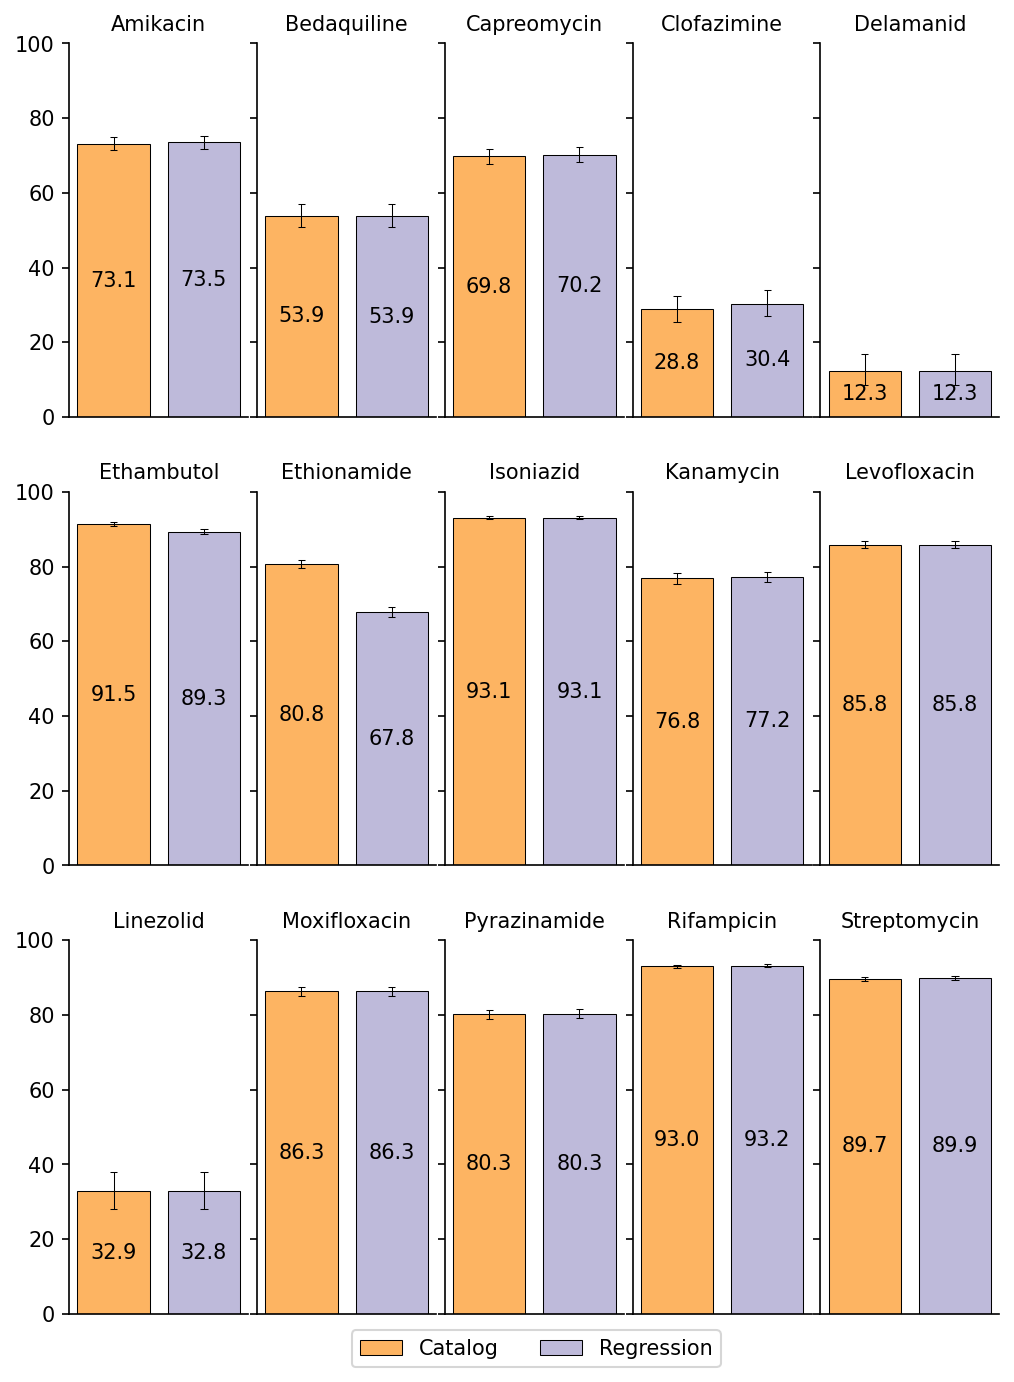

In [30]:
catalog_vs_reg_stats = single_metric_catalog_regression(drugs_lst, metric="Sens", plot=True)

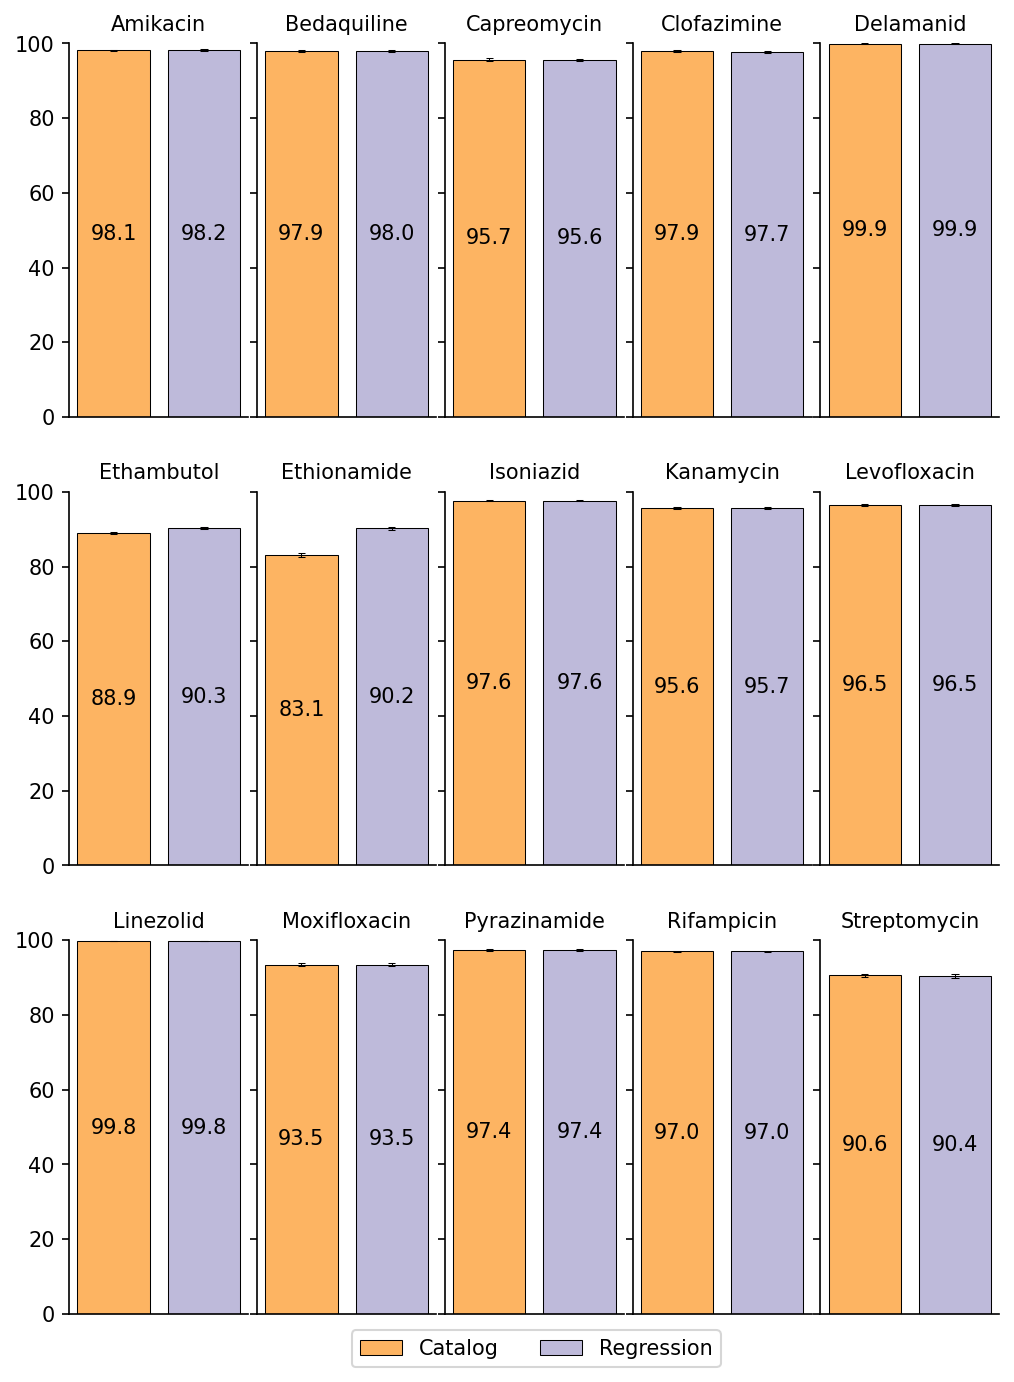

In [31]:
catalog_vs_reg_stats = single_metric_catalog_regression(drugs_lst, metric="Spec", plot=True)

# Digging into Specific Discrepancies

In [24]:
drug = "Moxifloxacin"

# MXF_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
genos_df = pd.read_csv(os.path.join(analysis_dir, drug, "genos_1.csv.gz"), compression="gzip", usecols=['sample_id', 'resolved_symbol', 'variant_category', 'variant_allele_frequency'])

In [25]:
MIC_df = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_mic.csv"))
MIC_df, most_common_medium = normalize_MICs_return_dataframe(drug, MIC_df, cc_df)

pheno_col = "norm_MIC"
print(f"    Min MIC: {np.min(MIC_df[pheno_col].values)}, Max MIC: {np.max(MIC_df[pheno_col].values)} in {most_common_medium}")

cc = cc_df.query("Drug == @drug & Medium==@most_common_medium").Value.values[0]
print(f"    Critical concentration = {cc} in {most_common_medium}")

    Dropped 97/12740 isolates in ['Frozen Broth Microdilution Plate (PMID31969421)', 'REMA', 'M24 BMD', '7H9'] without critical concentrations
    Min MIC: 0.03, Max MIC: 20.0 in UKMYC5
    Critical concentration = 1.0 in UKMYC5


In [26]:
susceptible_samples = MIC_df.query(f"{pheno_col} <= @cc").sample_id.values
df_plot = genos_df.query("sample_id in @susceptible_samples & resolved_symbol=='gyrA' & variant_category=='p.Ser95Thr'")
df_plot['gyrA_p.Ser95Thr'] = (df_plot['variant_allele_frequency'] > 0.75).astype(int)

# df_plot = genos_df.query("resolved_symbol=='mmpS5' & variant_category=='c.-74G>T'")
# df_plot['mmpS5_c.-74G>T'] = (df_plot['variant_allele_frequency'] > 0.75).astype(int)

# add MICs to the dataframe
df_plot = df_plot.merge(MIC_df, on="sample_id")

# add lineages
df_plot = df_plot.merge(lineages.rename(columns={"Sample_ID": "sample_id"}), on="sample_id", how="left")
print(len(df_plot))

10707


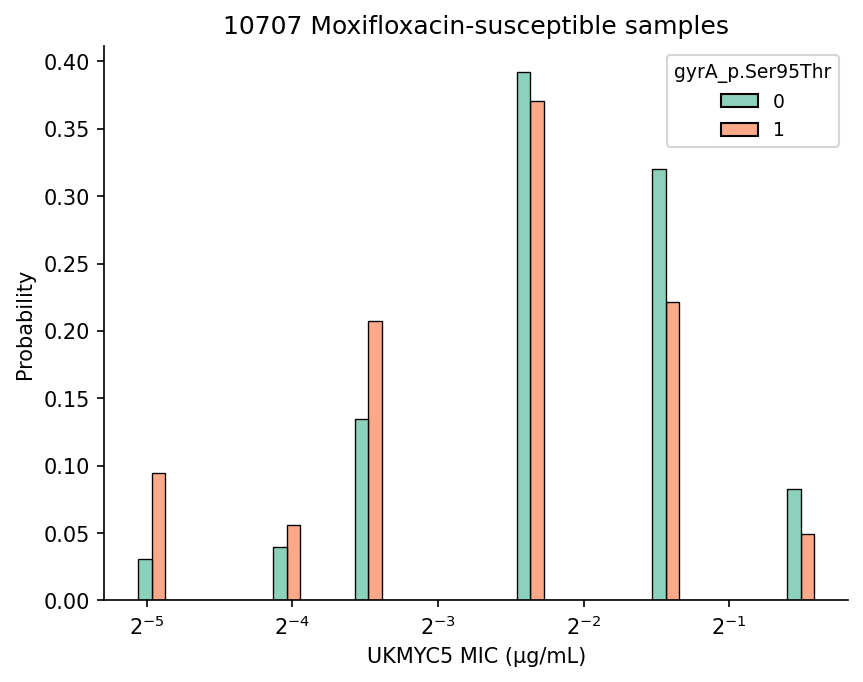

In [28]:
fig, ax = plt.subplots()

sns.histplot(data=df_plot,
             x='mic_value',
             stat='probability',
             common_norm=False,
             multiple='dodge',
             hue='gyrA_p.Ser95Thr',
             #hue='mmpS5_c.-74G>T',
             log_scale=2,
             palette="Set2",
             ax=ax
            )

sns.move_legend(ax, loc='best', title_fontsize=9, fontsize=9)

plt.xlabel(f"{most_common_medium} MIC (µg/mL)")
# plt.title(f"{len(df_plot)} samples with {drug} MICs")
plt.title(f"{len(df_plot)} {drug}-susceptible samples")
sns.despine()
plt.show()
# plt.savefig(f"../results/Figures/{drug}_MICs_mmpS5.png", dpi=300)

In [44]:
results_final.loc[(results_final['FINAL CONFIDENCE GRADING']=='Assoc w S') & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')].shape

(4, 60)

In [45]:
results_final.loc[(results_final['FINAL CONFIDENCE GRADING']=='Assoc w S') & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')]

,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,WHO_BH_LRT_neutral_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,UNPOOLED CONFIDENCE GRADING,Reason,POOLED CONFIDENCE GRADING,FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,Drug
720,eis_p.Met1?,start_lost,0.913753,0.000,0.000000,1.000,1.0,0.083309,0.996018,1.0,...,0.001572,0.999322,0.999868,Assoc w S,Assoc w S,Upgrade using ALL Evidence,Assoc w S,Assoc w S,3) Uncertain significance,Amikacin
723,eis_p.His150fs,frameshift,0.867666,0.000,0.000000,1.000,1.0,0.000904,0.999980,1.0,...,0.001572,0.998721,0.999534,Assoc w S,Assoc w S,WHO ALL Same Grading,Assoc w S,Assoc w S,3) Uncertain significance,Amikacin
14937,gyrA_p.Asp293Tyr,missense_variant,0.906860,0.000,0.000000,1.000,1.0,0.025490,0.998363,1.0,...,0.000663,0.999269,0.999840,Assoc w S,Assoc w S,WHO ALL Same Grading,Assoc w S,Assoc w S,3) Uncertain significance,Levofloxacin
19451,rpoB_c.-83A>G,upstream_gene_variant,0.939899,0.002,0.010688,0.998,1.0,0.520458,0.928631,1.0,...,0.000792,0.998570,0.999315,Assoc w S,Assoc w S,Upgrade using ALL Evidence,Assoc w S,Assoc w S,3) Uncertain significance,Rifampicin


In [47]:
len(results_final.loc[(results_final['FINAL CONFIDENCE GRADING']=='Neutral') & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')])

185

In [ ]:
The 4 variants graded Group 3 by SOLO and Group 5 by regression are eis_p.Met1?	and eis_p.His150fs (Amikacin), gyrA_p.Asp293Tyr	(Levofloxacin), and rpoB_c.-83A>G (Rifampicin).

In [8]:
results_final.loc[(results_final['FINAL CONFIDENCE GRADING']=='Assoc w R') & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')].shape

(149, 60)

In [25]:
results_final.loc[(results_final['FINAL CONFIDENCE GRADING']=='Assoc w R') & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')].Drug.value_counts()

Drug
Streptomycin    49
Ethambutol      41
Isoniazid       29
Ethionamide     14
Pyrazinamide     6
Rifampicin       5
Levofloxacin     4
Moxifloxacin     1
Name: count, dtype: int64

In [28]:
results_final.query("mutation=='rpoB_p.Leu378Arg'")

,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,WHO_BH_LRT_neutral_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,UNPOOLED CONFIDENCE GRADING,Reason,POOLED CONFIDENCE GRADING,FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,Drug
18280,rpoB_p.Leu378Arg,missense_variant,1.073031,0.0,0.0,0.993,1.0,0.031829,0.997941,1.0,...,0.001424,0.999819,0.999999,Possible Assoc w R,Assoc w R - Interim,Downgrade using ALL Evidence,Assoc w R - Interim,Assoc w R - Interim,3) Uncertain significance,Rifampicin


In [29]:
search_mutations = results_final.loc[(results_final['FINAL CONFIDENCE GRADING']=='Assoc w R') & (results_final['SOLO FINAL CONFIDENCE GRADING']=='2) Assoc w R - Interim') & (results_final['Drug']=='Pyrazinamide')].mutation.values
len(search_mutations)

131

In [31]:
results_final.loc[(results_final['FINAL CONFIDENCE GRADING']=='Assoc w R') & (results_final['SOLO FINAL CONFIDENCE GRADING']=='2) Assoc w R - Interim') & (results_final['Drug']=='Pyrazinamide')].predicted_effect.value_counts()

predicted_effect
missense_variant         79
frameshift               37
stop_gained               6
inframe_deletion          4
upstream_gene_variant     2
stop_lost                 2
feature_ablation          1
Name: count, dtype: int64

In [36]:
results_final.loc[(results_final['FINAL CONFIDENCE GRADING']=='Assoc w R') & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['Drug']=='Rifampicin')][['mutation', 'ALL_Odds_Ratio']]

,mutation,ALL_Odds_Ratio
18217,rpoB_p.Ile491Leu,1.110584
18224,rpoB_p.Phe424Val,1.091412
18226,rpoB_p.Ser493Leu,1.090038
18233,rpoB_p.Ile491Met,1.074172
18241,rpoB_p.Ile491Thr,1.064873


In [19]:
results_final.query("mutation=='ethA_p.Arg463fs'")[['mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval']]

,mutation,WHO_Odds_Ratio,WHO_BH_pval,ALL_Odds_Ratio,ALL_BH_pval
8985,ethA_p.Arg463fs,0.988052,0.498618,1.036471,0.05251


In [24]:
results_final.query("mutation in ['rpoB_p.Lys446Gln', 'rpoB_p.Asn437Asp']")[['mutation', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'POOLED CONFIDENCE GRADING', 'UNPOOLED CONFIDENCE GRADING', 'Reason', 'FINAL CONFIDENCE GRADING']]

,mutation,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset,POOLED CONFIDENCE GRADING,UNPOOLED CONFIDENCE GRADING,Reason,FINAL CONFIDENCE GRADING
18786,rpoB_p.Asn437Asp,Uncertain,Neutral,Neutral,Neutral,Neutral in ALL,Neutral
18797,rpoB_p.Lys446Gln,Uncertain,Neutral,Uncertain,Neutral,Pooled Unpooled Different,Neutral


In [ ]:
rpoB_p.Asn437Asp and rpoB_p.Lys446Gln are graded Uncertain in the WHO dataset and Neutral in the ALL dataset, 

# Volcano Plots of MIC Results for Mutations 1) Assoc w R by Regression and Uncertain by SOLO

In [10]:
len(results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')])

642

In [11]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'] != 'Uncertain') & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')][['REGRESSION FINAL CONFIDENCE GRADING']].value_counts()

REGRESSION FINAL CONFIDENCE GRADING
Assoc w R - Interim                    444
Neutral                                238
Assoc w R                              198
Assoc w S - Interim                     14
Assoc w S                                4
Name: count, dtype: int64

In [12]:
len(results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')])#[['REGRESSION FINAL CONFIDENCE GRADING']])

660

# MIC Results Volcano Plot

In [23]:
combined_MIC_results = results_final.merge(MIC_results, on=['Drug', 'mutation'], how='right')
len(combined_MIC_results), len(MIC_results)

(10546, 10546)

In [40]:
significant_MIC = combined_MIC_results.query("MIC_BH_pval <= 0.05")

In [42]:
significant_MIC.query("(WHO_Odds_Ratio > 1 & WHO_BH_pval <= 0.05 & MIC_coef < 0) | (WHO_Odds_Ratio < 1 & WHO_BH_pval <= 0.05 & MIC_coef > 0)")[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'MIC_coef', 'MIC_BH_pval', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'REGRESSION INITIAL CONFIDENCE GRADING', 'REGRESSION FINAL CONFIDENCE GRADING']]

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,MIC_coef,MIC_BH_pval,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION INITIAL CONFIDENCE GRADING,REGRESSION FINAL CONFIDENCE GRADING
1346,Bedaquiline,Rv0678_p.Tyr145*,1.059337,0.040147,1.040317,0.012722,-0.028771,0.0,3) Uncertain significance,2) Assoc w R - Interim,Uncertain,Uncertain
1360,Bedaquiline,mmpS5_c.-74G>T,1.409350,0.000000,1.219286,0.000000,-0.042476,0.0,5) Not assoc w R,4) Not assoc w R - Interim,Uncertain,Assoc w R - Interim
6245,Kanamycin,eis_p.Thr269fs,1.113275,0.000000,1.007146,0.883227,-0.056977,0.0,3) Uncertain significance,3) Uncertain significance,Neutral,Neutral


In [44]:
significant_MIC.query("(ALL_Odds_Ratio > 1 & ALL_BH_pval <= 0.05 & MIC_coef < 0) | (ALL_Odds_Ratio < 1 & ALL_BH_pval <= 0.05 & MIC_coef > 0)")[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'MIC_coef', 'MIC_BH_pval', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'REGRESSION INITIAL CONFIDENCE GRADING', 'REGRESSION FINAL CONFIDENCE GRADING']]

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,MIC_coef,MIC_BH_pval,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION INITIAL CONFIDENCE GRADING,REGRESSION FINAL CONFIDENCE GRADING
1346,Bedaquiline,Rv0678_p.Tyr145*,1.059337,0.040147,1.040317,0.012722,-0.028771,0.0,3) Uncertain significance,2) Assoc w R - Interim,Uncertain,Uncertain
1360,Bedaquiline,mmpS5_c.-74G>T,1.409350,0.000000,1.219286,0.000000,-0.042476,0.0,5) Not assoc w R,4) Not assoc w R - Interim,Uncertain,Assoc w R - Interim
3448,Ethionamide,mshA_p.Ala187Val,1.013597,0.481079,1.090265,0.000000,-0.044874,0.0,5) Not assoc w R,5) Not assoc w R,Uncertain,Uncertain
8569,Ethambutol,embC_c.-1188C>T,1.030252,0.837759,1.084668,0.000000,-0.177006,0.0,5) Not assoc w R,4) Not assoc w R - Interim,Uncertain,Uncertain


In [13]:
# variants graded in Groups 1, 2, 4, and 5 by regression and 3 by DA
search_df = results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['ALL_Num_Isolates'] >= 5)].reset_index(drop=True)
print(search_df.shape)
print(search_df['REGRESSION FINAL CONFIDENCE GRADING'].value_counts())

MIC_results = []

for drug in drugs_lst:

    for model_path in ["dropAF_noSyn_unpooled", "dropAF_noSyn_poolSeparate", "dropAF_withSyn_unpooled"]:
        df = pd.read_csv(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/{drug}/MIC/tiers=1/{model_path}/model_analysis.csv")
        df['Drug'] = drug
        MIC_results.append(df)

MIC_results = pd.concat(MIC_results).drop_duplicates(["Drug", "mutation"], keep="first")[['Drug', 'mutation', 'coef', 'BH_pval']].rename(columns={'coef': 'MIC_coef', 'BH_pval': 'MIC_BH_pval'})

search_df = search_df.merge(MIC_results, on=['Drug', 'mutation'], how='left')

print(f"{len(search_df.loc[~pd.isnull(search_df['MIC_BH_pval'])])}/{len(search_df)} ({len(search_df.loc[~pd.isnull(search_df['MIC_BH_pval'])])/len(search_df)*100})% have MIC results")

plot_df = search_df.loc[~pd.isnull(search_df['MIC_BH_pval'])]

print(search_df.shape, plot_df.shape)

(358, 63)
REGRESSION FINAL CONFIDENCE GRADING
Assoc w R              190
Assoc w R - Interim    154
Assoc w S - Interim     10
Assoc w S                4
Name: count, dtype: int64
296/358 (82.68156424581005)% have MIC results
(358, 65) (296, 65)


In [75]:
# negative log-p-value
plot_df['log_MIC_BH_pval'] = -np.log(plot_df['MIC_BH_pval'])

# # for variants with a p-value of 0, replace with the next smallest p-value
# plot_df.loc[plot_df['MIC_BH_pval'] == 0, 'log_MIC_BH_pval'] = -np.log(np.sort(plot_df['MIC_BH_pval'].unique())[1])

# plot_df.loc[(plot_df['MIC_coef'] > 0) & (plot_df['MIC_BH_pval'] <= 0.05) & (~plot_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')), 'color'] = sns.color_palette("Paired").as_hex()[1] #'cornflowerblue'

# plot_df.loc[(plot_df['MIC_coef'] > 0) & (plot_df['MIC_BH_pval'] <= 0.05) & (plot_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')), 'color'] = sns.color_palette("Paired").as_hex()[0]

# plot_df.loc[(plot_df['MIC_coef'] < 0) & (plot_df['MIC_BH_pval'] <= 0.05)  & (~plot_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')), 'color'] = sns.color_palette("Paired").as_hex()[5] #'darkred'

# plot_df.loc[(plot_df['MIC_coef'] < 0) & (plot_df['MIC_BH_pval'] <= 0.05) & (plot_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')), 'color'] = sns.color_palette("Paired").as_hex()[4]

# for variants with a p-value of 0, replace with the next smallest p-value
plot_df.loc[plot_df['MIC_BH_pval'] == 0, 'log_MIC_BH_pval'] = -np.log(np.sort(plot_df['MIC_BH_pval'].unique())[1])

plot_df.loc[(plot_df['MIC_coef'] > 0) & (plot_df['MIC_BH_pval'] <= 0.05), 'color'] = 'cornflowerblue'
plot_df.loc[(plot_df['MIC_coef'] < 0) & (plot_df['MIC_BH_pval'] <= 0.05), 'color'] = 'darkred'

plot_df.loc[plot_df['MIC_BH_pval'] > 0.05, 'color'] = 'lightgray'

#color_dict = dict(zip(plot_df.query("color != 'lightgray'")['REGRESSION FINAL CONFIDENCE GRADING'], plot_df.query("color != 'lightgray'")['color']))

print(plot_df.shape)

(296, 67)


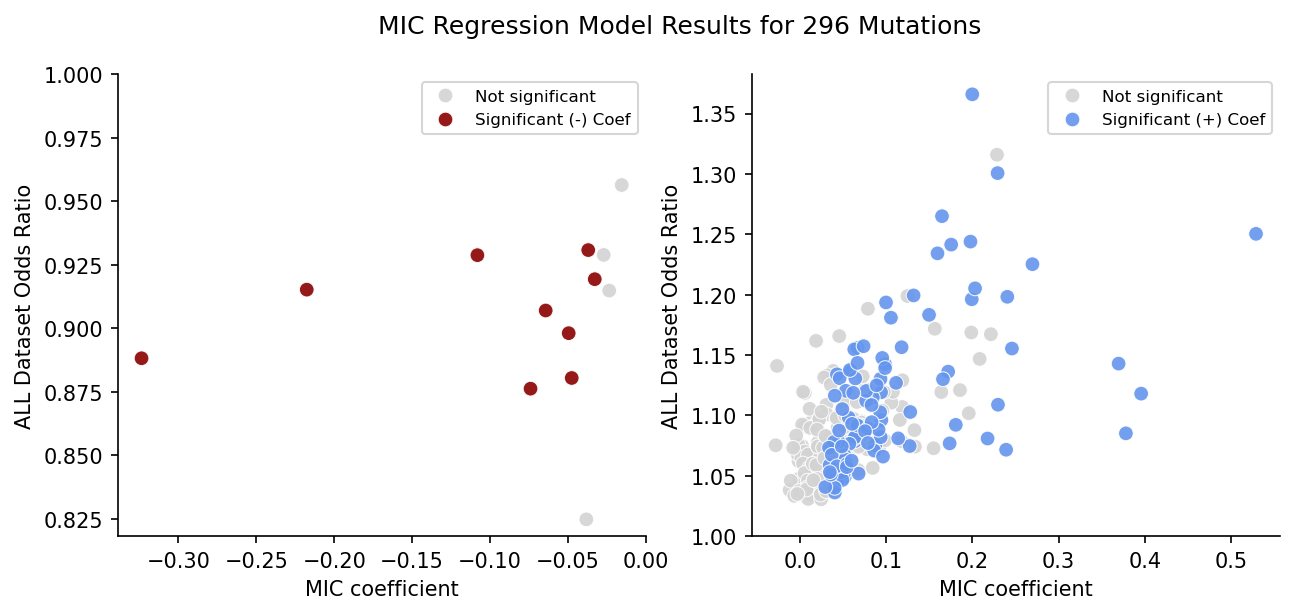

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=plot_df.query("ALL_Odds_Ratio < 1").sort_values('color', ascending=False), # put lightgray at the beginning so it gets plotted below
                x='MIC_coef',
                y='ALL_Odds_Ratio',
                #y='log_MIC_BH_pval',
                hue='color',
                palette={color:color for color in plot_df.color.unique()},
                #palette={'Assoc w R': sns.color_palette("Paired")[1], 'Assoc w R - Interim': sns.color_palette("Paired")[0], 'Assoc w S': sns.color_palette("Paired")[5], 'Assoc w S - Interim': sns.color_palette("Paired")[4]},
                legend=True,
                alpha=0.9,
                linewidth=0.5,
                s=50,
                ax=axs[0]
               )

sns.scatterplot(data=plot_df.query("ALL_Odds_Ratio > 1").sort_values('color', ascending=False), # put lightgray at the beginning so it gets plotted below
                x='MIC_coef',
                y='ALL_Odds_Ratio',
                #y='log_MIC_BH_pval',
                hue='color',
                palette={color:color for color in plot_df.color.unique()},
                #palette={'Assoc w R': sns.color_palette("Paired")[1], 'Assoc w R - Interim': sns.color_palette("Paired")[0], 'Assoc w S': sns.color_palette("Paired")[5], 'Assoc w S - Interim': sns.color_palette("Paired")[4]},
                legend=True,
                alpha=0.9,
                linewidth=0.5,
                s=50,
                ax=axs[1]
               )

# max_val = np.max([np.abs(plot_df.MIC_coef.min()), np.abs(plot_df.MIC_coef.max())]) * 1.1
# plt.xlim(-max_val, max_val)

axs[0].set_xlim(right=0)
axs[0].set_ylim(top=1)

# axs[1].set_xlim(left=0-0.01)
axs[1].set_ylim(bottom=1)

for ax in axs:
    ax.set_xlabel("MIC coefficient")
    ax.set_ylabel("ALL Dataset Odds Ratio")

# manually create a legend
handles_0, _ = axs[0].get_legend_handles_labels()
ax0_dict = {'lightgray': 'Not significant', 'darkred': 'Significant (-) Coef'}

handles_1, _ = axs[1].get_legend_handles_labels()
ax1_dict = {'lightgray': 'Not significant', 'cornflowerblue': 'Significant (+) Coef'}

axs[0].legend(handles_0, list(ax0_dict.values()), fontsize=8)
axs[1].legend(handles_1, list(ax1_dict.values()), fontsize=8)

plt.suptitle(f"MIC Regression Model Results for {len(plot_df)} Mutations")
sns.despine()
plt.savefig("../results/Figures/MIC_volcano_plots.png", dpi=300, bbox_inches='tight')

In [88]:
plot_df.query("MIC_BH_pval > 0.05 & ALL_Odds_Ratio < 0.85")

,Drug,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,...,POOLED CONFIDENCE GRADING,ALL_single_lineage,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION INITIAL CONFIDENCE GRADING,REGRESSION FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,log_MIC_BH_pval,color
168,Isoniazid,katG_c.-507C>G,upstream_gene_variant,0.826331,0.0,0.0,1.0,1.0,0.009072,0.999552,...,Uncertain,NaN,3) Uncertain significance,3) Uncertain significance,Uncertain,Assoc w S - Interim,-0.038253,0.475602,0.743174,lightgray


In [114]:
search_df.query("MIC_BH_pval > 0.05 & Drug=='Rifampicin'").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')][['mutation', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'WHO_Num_Isolates', 'ALL_Num_Isolates', 'ALL_single_lineage', 'REGRESSION INITIAL CONFIDENCE GRADING', 'REGRESSION FINAL CONFIDENCE GRADING']]

,mutation,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,WHO_Num_Isolates,ALL_Num_Isolates,ALL_single_lineage,REGRESSION INITIAL CONFIDENCE GRADING,REGRESSION FINAL CONFIDENCE GRADING
253,rpoB_p.Ile491Leu,1.110584,0.0,0.000030,10.0,31.0,NaN,Assoc w R,Assoc w R
254,rpoB_p.Ile491Met,1.074172,0.0,0.000005,13.0,19.0,NaN,Assoc w R,Assoc w R
255,rpoB_p.Ile491Thr,1.064873,0.0,0.029397,7.0,9.0,2.2.1,Assoc w R,Assoc w R
256,rpoB_p.Leu378Arg,1.038195,0.0,0.157514,11.0,15.0,NaN,Assoc w R - Interim,Assoc w R - Interim
260,rpoB_p.Phe424Val,1.091412,0.0,0.000787,14.0,18.0,NaN,Assoc w R,Assoc w R
264,rpoB_p.Ser493Leu,1.090038,0.0,0.000047,13.0,17.0,NaN,Assoc w R,Assoc w R


In [133]:
search_df.query("MIC_BH_pval > 0.05 & Drug=='Isoniazid'").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')].shape

(32, 65)

In [116]:
search_df.query("MIC_BH_pval > 0.05 & Drug=='Isoniazid'").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')][['mutation', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'WHO_Num_Isolates', 'ALL_Num_Isolates', 'ALL_single_lineage', 'REGRESSION INITIAL CONFIDENCE GRADING', 'REGRESSION FINAL CONFIDENCE GRADING']].shape

(27, 9)

In [127]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]
print(len(np.unique(compens_lst)))

13


In [135]:
search_df.query("MIC_BH_pval > 0.05 & Drug=='Isoniazid' & mutation in @compens_lst").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')].shape

(5, 65)

In [146]:
search_df.query("MIC_BH_pval > 0.05 & Drug=='Isoniazid' & mutation not in @compens_lst").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO FINAL CONFIDENCE GRADING']!='3) Uncertain significance')].shape

(5, 65)

In [151]:
search_df.query("MIC_BH_pval > 0.05 & Drug=='Isoniazid' & mutation not in @compens_lst").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance') & (search_df['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')][['mutation', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'WHO_Num_Isolates', 'ALL_Num_Isolates', 'ALL_single_lineage', 'REGRESSION FINAL CONFIDENCE GRADING']].sort_values("ALL_Odds_Ratio", ascending=False)

,mutation,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,WHO_Num_Isolates,ALL_Num_Isolates,ALL_single_lineage,REGRESSION FINAL CONFIDENCE GRADING
154,ahpC_p.Asp73His,1.131391,0.000000,1.811081e-03,27.0,74.0,4.1.1.3,Assoc w R
161,inhA_c.-809G>A,1.118557,0.000000,7.382521e-03,26.0,28.0,4,Assoc w R
193,katG_p.Ser315Gly,1.098433,0.000000,6.011380e-05,20.0,29.0,NaN,Assoc w R
175,katG_p.Asn138Ser,1.095145,0.000000,1.556539e-09,7.0,8.0,NaN,Assoc w R
182,katG_p.Gly279Asp,1.094948,0.000000,1.460834e-09,4.0,8.0,NaN,Assoc w R - Interim
171,katG_p.Ala110Val,1.089810,0.000000,3.288634e-02,11.0,14.0,NaN,Assoc w R
188,katG_p.Leu141Ser,1.088182,0.000000,1.713429e-03,5.0,11.0,NaN,Assoc w R
194,katG_p.Trp161Arg,1.086270,0.000000,2.595468e-07,5.0,7.0,NaN,Assoc w R
166,katG_c.-10A>C,1.083659,0.000000,5.880203e-03,4.0,10.0,NaN,Assoc w R - Interim
197,katG_p.Tyr337Cys,1.076692,0.004782,2.981800e-03,5.0,10.0,NaN,Assoc w R


In [162]:
results_final.query("mutation in @compens_lst").merge(MIC_results.query("mutation in @compens_lst"), how='left').sort_values("ALL_Odds_Ratio", ascending=False)[['mutation', 'MIC_coef', 'MIC_BH_pval', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']]

,mutation,MIC_coef,MIC_BH_pval,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
6,ahpC_c.-57C>T,0.045569,0.469011,3) Uncertain significance,3) Uncertain significance
1,ahpC_c.-48G>A,0.018680,0.528568,3) Uncertain significance,3) Uncertain significance
4,ahpC_c.-52C>T,0.038560,0.528568,3) Uncertain significance,3) Uncertain significance
5,ahpC_c.-54C>T,0.032139,0.528568,3) Uncertain significance,3) Uncertain significance
9,ahpC_c.-76T>A,0.042203,0.528568,3) Uncertain significance,3) Uncertain significance
0,ahpC_c.-47_-46insT,0.057447,0.314347,3) Uncertain significance,3) Uncertain significance
7,ahpC_c.-72C>T,0.113945,0.018925,3) Uncertain significance,3) Uncertain significance
3,ahpC_c.-52C>A,-0.014405,0.528568,3) Uncertain significance,3) Uncertain significance
2,ahpC_c.-51G>A,0.036073,0.528568,3) Uncertain significance,3) Uncertain significance
11,ahpC_c.-81C>T,-0.060687,0.528568,3) Uncertain significance,3) Uncertain significance


In [128]:
The ORs are small, ranging from 1.04-1.13 in the ALL dataset.

['ahpC_c.-47_-46insT',
 'ahpC_c.-48G>A',
 'ahpC_c.-51G>A',
 'ahpC_c.-81C>T',
 'ahpC_c.-76T>A',
 'ahpC_c.-57C>T',
 'ahpC_c.-52C>T',
 'ahpC_c.-52C>A',
 'ahpC_c.-88_-87insAT',
 'ahpC_c.-77T>G',
 'ahpC_c.-72C>T',
 'ahpC_c.-54C>T',
 'ahpC_c.-74G>A']

In [130]:
search_df.query("MIC_BH_pval > 0.05 & Drug=='Isoniazid'").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')].shape

(27, 65)

# 